# **Import and Install**

In [1]:
import re
import os
import string
import collections
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, TrainingArguments, AutoModelForSequenceClassification, AutoModelForTokenClassification, Trainer, DataCollatorForTokenClassification
from sklearn.model_selection import train_test_split
from transformers import pipeline
from sklearn.metrics import f1_score
from lime.lime_text import LimeTextExplainer
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from wordcloud import WordCloud
from datasets import Dataset, DatasetDict, Features, Sequence, ClassLabel, Value

c:\Users\timot\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['WANDB_MODE'] = 'disabled'

# **Dataset Preprocessing**

In [3]:
df = pd.read_csv('../datasets/apple_iphone_11_reviews.csv')

In [4]:
print(f'Before:\n{df.isnull().sum()}')
df.dropna(subset=['review_text'], inplace=True)
df.dropna(subset=['review_title'], inplace=True)
print()
print(f'After:\n{df.isnull().sum()}')

Before:
index              0
product            0
helpful_count      0
total_comments     0
url                0
review_country     0
reviewed_at        0
review_text        3
review_rating      0
product_company    0
profile_name       0
review_title       2
dtype: int64

After:
index              0
product            0
helpful_count      0
total_comments     0
url                0
review_country     0
reviewed_at        0
review_text        0
review_rating      0
product_company    0
profile_name       0
review_title       0
dtype: int64


## **EDA**

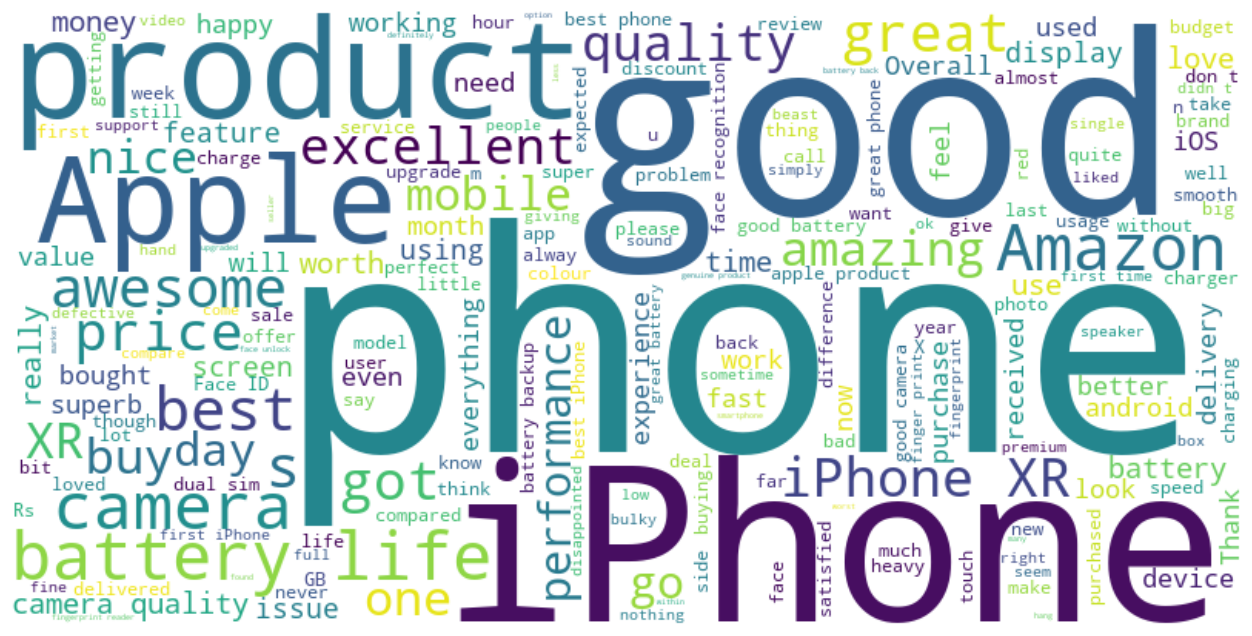

In [5]:
text = ''.join(df['review_text'].astype(str))
wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color="white").generate_from_text(text)

plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

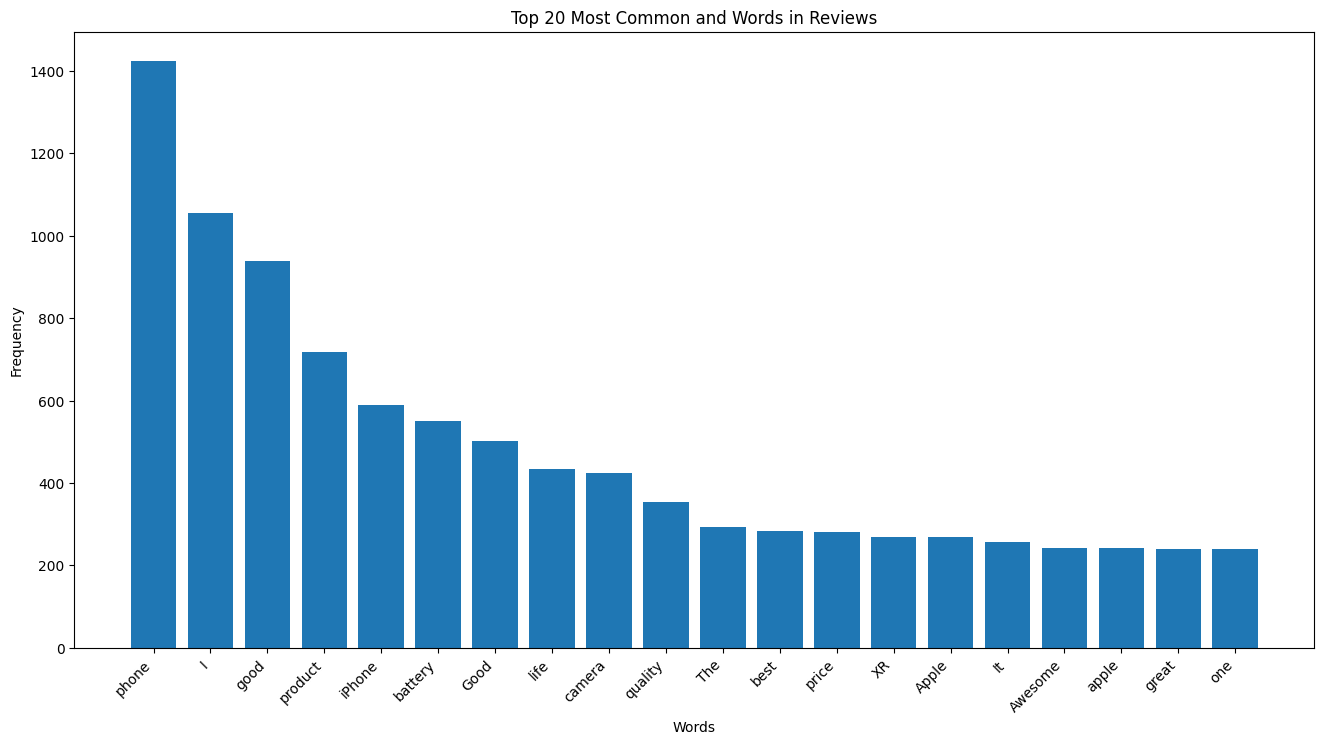

In [6]:
plt.figure(figsize=(16, 8))
reviews = df['review_text']
all_words = []
for text in reviews:
  sentences = word_tokenize(str(text))
  words = [word for word in sentences if word not in string.punctuation]
  words = [word for word in words if word not in stopwords.words('english')]
  words = [word for word in words if word.isalpha()]
  all_words.extend(words)

word_freq = collections.Counter(all_words)
common_words = word_freq.most_common(20)
words, frequencies = zip(*common_words)

plt.bar(words, frequencies)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common and Words in Reviews')
plt.show()

# **Sentiment Analysis**

## **Copy dataframe for Sentiment Analysis purpose**

In [7]:
sentiment_df = df

## **Data Labeling**

In [8]:
def label_rating(review_rating):
  match = re.search(r'(\d+(\.\d+))\s*out of 5 stars', review_rating)
  if match:
    return float(match.group(1))
  else:
    return None

sentiment_df['numeric_rating'] = sentiment_df['review_rating'].apply(label_rating)
print(sentiment_df['numeric_rating'])


none_values = sentiment_df['numeric_rating'].isna()
none_count = none_values.sum()
print("None values: ", none_count)

0       3.0
1       1.0
2       5.0
3       1.0
4       5.0
       ... 
5005    4.0
5006    4.0
5007    5.0
5008    5.0
5009    5.0
Name: numeric_rating, Length: 5007, dtype: float64
None values:  0


In [9]:
def apply_labels(numeric_rating):
  if numeric_rating < 3:
    label = 'bad'
  elif numeric_rating == 3:
    label = 'neutral'
  else:
    label = 'good'
  return label

sentiment_df['label'] = sentiment_df['numeric_rating'].apply(apply_labels)
print(sentiment_df['label'])

0       neutral
1           bad
2          good
3           bad
4          good
         ...   
5005       good
5006       good
5007       good
5008       good
5009       good
Name: label, Length: 5007, dtype: object


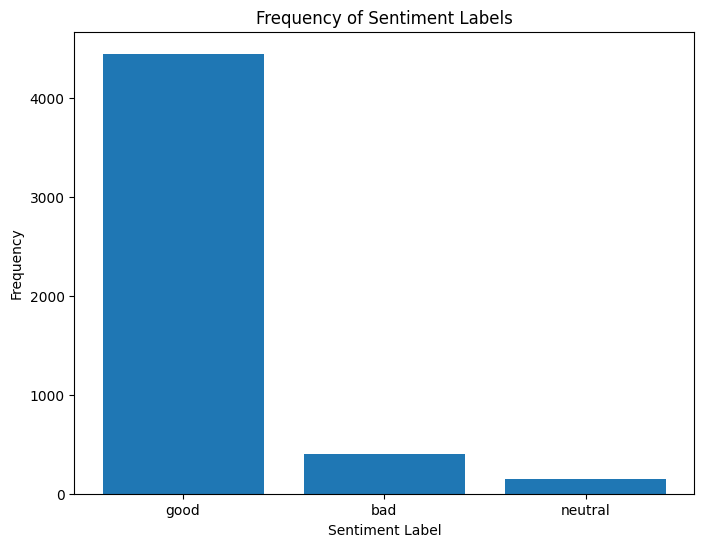

In [10]:
label_counts = sentiment_df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Frequency of Sentiment Labels')
plt.show()

## **Data Resampling**

In [11]:
neutral = sentiment_df[sentiment_df['label'] == 'neutral']
bad = sentiment_df[sentiment_df['label'] == 'bad']
good = sentiment_df[sentiment_df['label'] == 'good']

neutral_upsampled = neutral.sample(n=len(good), replace=True, random_state = 20)
bad_upsampled = bad.sample(n=len(good), replace=True, random_state = 20)

up_data = pd.concat([neutral_upsampled, bad_upsampled, good])

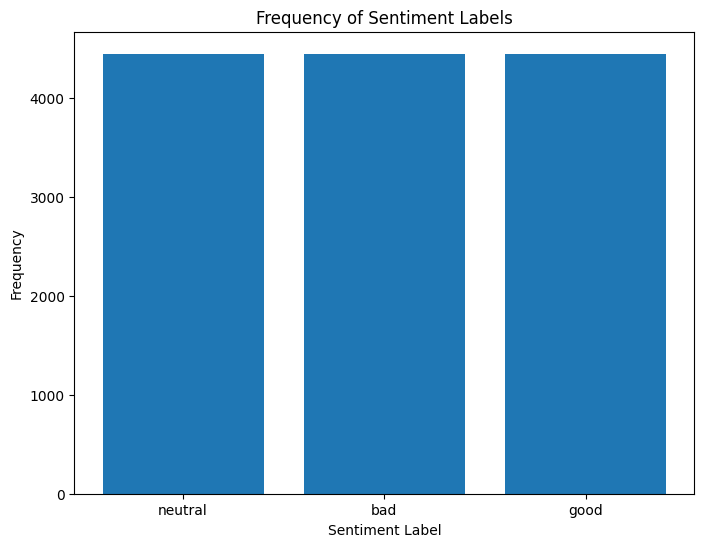

In [12]:
label_counts = up_data['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Frequency of Sentiment Labels')
plt.show()

## **Train test split**

In [13]:
train, eval = train_test_split(up_data,train_size=0.8,stratify=up_data['label'])

print(train)
print(eval)

      index                         product helpful_count  total_comments  \
2528   2528  Apple iPhone XR (64GB) - Black             0               0   
4594   4594  Apple iPhone XR (64GB) - Black             0               0   
1744   1744  Apple iPhone XR (64GB) - Black             0               0   
4438   4438  Apple iPhone XR (64GB) - Black             0               0   
4293   4293  Apple iPhone XR (64GB) - Black             0               0   
...     ...                             ...           ...             ...   
1867   1867  Apple iPhone XR (64GB) - Black             0               0   
782     782  Apple iPhone XR (64GB) - Black             0               0   
3740   3740  Apple iPhone XR (64GB) - Black             0               0   
4920   4920  Apple iPhone XR (64GB) - Black             0               0   
4971   4971  Apple iPhone XR (64GB) - Black             0               0   

                                                    url review_country  \
2

## **Training Model**

### **Tokenizing**

In [14]:
tokenizer=AutoTokenizer.from_pretrained('distilbert-base-cased')

In [15]:
train['review_text'] = train['review_text'].astype(str)
eval['review_text'] = eval['review_text'].astype(str)

label_mapping = {'bad': 0, 'neutral': 1, 'good': 2}

train['label'] = train['label'].map(label_mapping)
eval['label'] = eval['label'].map(label_mapping)

train_dataset = Dataset.from_pandas(train[['review_text', 'label']])
eval_dataset = Dataset.from_pandas(eval[['review_text', 'label']])

def tokenize_data(batch):
  tokenized_batch = tokenizer(batch['review_text'], padding='max_length', truncation=True, max_length=512)
  tokenized_batch['labels'] = batch['label']
  return tokenized_batch

train_dataset = train_dataset.map(tokenize_data, batched=True)
eval_dataset = eval_dataset.map(tokenize_data, batched=True)

print(train['label'].head())
print(eval['label'].head())
print(train_dataset[0])


Map: 100%|██████████| 2669/2669 [00:00<00:00, 10135.06 examples/s]

2528    2
4594    2
1744    1
4438    0
4293    2
Name: label, dtype: int64
1795    0
875     0
1914    0
2338    2
2580    1
Name: label, dtype: int64
{'review_text': 'Nice Phone.', 'label': 2, '__index_level_0__': 2528, 'input_ids': [101, 8835, 26385, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [16]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1-score": f1}

In [17]:
trainargs=TrainingArguments(
	output_dir='../model/sentiment_analysis/checkpoint',
  num_train_epochs=5,
  evaluation_strategy="epoch",
  save_strategy='epoch',
  load_best_model_at_end=True,
  push_to_hub=False
)

c:\Users\timot\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### **Training**

In [18]:
model_name = 'distilbert-base-cased'
num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

trainer = Trainer(
  model=model,
  args=trainargs,
  train_dataset=train_dataset,
  eval_dataset=eval_dataset,
  tokenizer=tokenizer,
  compute_metrics=compute_metrics,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  8%|▊         | 501/6675 [01:03<12:51,  8.00it/s]

{'loss': 0.535, 'grad_norm': 17.16755485534668, 'learning_rate': 4.625468164794008e-05, 'epoch': 0.37}


 15%|█▍        | 1001/6675 [02:05<11:44,  8.06it/s]

{'loss': 0.2361, 'grad_norm': 0.03292803093791008, 'learning_rate': 4.250936329588015e-05, 'epoch': 0.75}


                                                   
 20%|██        | 1335/6675 [02:59<11:02,  8.06it/s]

{'eval_loss': 0.09311449527740479, 'eval_f1-score': 0.9751987185954231, 'eval_runtime': 13.7224, 'eval_samples_per_second': 194.499, 'eval_steps_per_second': 24.34, 'epoch': 1.0}


 22%|██▏       | 1501/6675 [03:21<10:40,  8.07it/s]  

{'loss': 0.1456, 'grad_norm': 1.5022814273834229, 'learning_rate': 3.876404494382023e-05, 'epoch': 1.12}


 30%|██▉       | 2001/6675 [04:22<09:39,  8.07it/s]

{'loss': 0.1391, 'grad_norm': 56.539485931396484, 'learning_rate': 3.5018726591760305e-05, 'epoch': 1.5}


 37%|███▋      | 2501/6675 [05:24<08:35,  8.10it/s]

{'loss': 0.1095, 'grad_norm': 0.061140671372413635, 'learning_rate': 3.1273408239700376e-05, 'epoch': 1.87}


                                                   
 40%|████      | 2670/6675 [06:02<08:43,  7.64it/s]

{'eval_loss': 0.10489121079444885, 'eval_f1-score': 0.9737451356155701, 'eval_runtime': 16.3742, 'eval_samples_per_second': 163.0, 'eval_steps_per_second': 20.398, 'epoch': 2.0}


 45%|████▍     | 3001/6675 [06:45<07:35,  8.06it/s]  

{'loss': 0.0916, 'grad_norm': 0.012687073089182377, 'learning_rate': 2.752808988764045e-05, 'epoch': 2.25}


 52%|█████▏    | 3501/6675 [07:46<06:34,  8.05it/s]

{'loss': 0.0693, 'grad_norm': 0.004526774398982525, 'learning_rate': 2.3782771535580524e-05, 'epoch': 2.62}


 60%|█████▉    | 4001/6675 [08:48<05:31,  8.08it/s]

{'loss': 0.0668, 'grad_norm': 0.6505425572395325, 'learning_rate': 2.00374531835206e-05, 'epoch': 3.0}


                                                   
 60%|██████    | 4005/6675 [09:02<05:36,  7.94it/s]

{'eval_loss': 0.09404528886079788, 'eval_f1-score': 0.9748074852586524, 'eval_runtime': 13.7161, 'eval_samples_per_second': 194.589, 'eval_steps_per_second': 24.351, 'epoch': 3.0}


 67%|██████▋   | 4501/6675 [10:04<04:40,  7.75it/s]  

{'loss': 0.0416, 'grad_norm': 0.0021190226543694735, 'learning_rate': 1.6292134831460676e-05, 'epoch': 3.37}


 75%|███████▍  | 5001/6675 [11:06<03:33,  7.84it/s]

{'loss': 0.061, 'grad_norm': 0.005395105108618736, 'learning_rate': 1.254681647940075e-05, 'epoch': 3.75}


                                                   
 80%|████████  | 5340/6675 [12:02<02:44,  8.10it/s]

{'eval_loss': 0.06416281312704086, 'eval_f1-score': 0.9801091399413949, 'eval_runtime': 13.7285, 'eval_samples_per_second': 194.412, 'eval_steps_per_second': 24.329, 'epoch': 4.0}


 82%|████████▏ | 5501/6675 [12:22<02:25,  8.06it/s]  

{'loss': 0.0391, 'grad_norm': 0.00233942037448287, 'learning_rate': 8.801498127340826e-06, 'epoch': 4.12}


 90%|████████▉ | 6001/6675 [13:24<01:25,  7.91it/s]

{'loss': 0.0361, 'grad_norm': 0.4321046769618988, 'learning_rate': 5.056179775280899e-06, 'epoch': 4.49}


 97%|█████████▋| 6501/6675 [14:26<00:21,  8.05it/s]

{'loss': 0.0343, 'grad_norm': 0.6887696385383606, 'learning_rate': 1.310861423220974e-06, 'epoch': 4.87}


                                                   
100%|██████████| 6675/6675 [15:01<00:00,  8.12it/s]

{'eval_loss': 0.06673530489206314, 'eval_f1-score': 0.9823621360433346, 'eval_runtime': 13.8405, 'eval_samples_per_second': 192.84, 'eval_steps_per_second': 24.132, 'epoch': 5.0}


100%|██████████| 6675/6675 [15:02<00:00,  7.40it/s]

{'train_runtime': 902.5825, 'train_samples_per_second': 59.136, 'train_steps_per_second': 7.395, 'train_loss': 0.12170371866404787, 'epoch': 5.0}


TrainOutput(global_step=6675, training_loss=0.12170371866404787, metrics={'train_runtime': 902.5825, 'train_samples_per_second': 59.136, 'train_steps_per_second': 7.395, 'total_flos': 7070573494656000.0, 'train_loss': 0.12170371866404787, 'epoch': 5.0})

## **Evaluation**

In [19]:
results = trainer.evaluate()
print("DistilBERT model:")
print("Evaluation results:", results)

100%|██████████| 334/334 [00:13<00:00, 23.93it/s]


DistilBERT model:
Evaluation results: {'eval_loss': 0.06416281312704086, 'eval_f1-score': 0.9801091399413949, 'eval_runtime': 14.0079, 'eval_samples_per_second': 190.535, 'eval_steps_per_second': 23.844, 'epoch': 5.0}


## **Save & Load Model**

In [20]:
trainer.save_model('../model/sentiment_analysis/sentiment_analysis_model')

In [21]:
model_sentiment = AutoModelForSequenceClassification.from_pretrained('../model/sentiment_analysis/sentiment_analysis_model')
tokenizer_sentiment = AutoTokenizer.from_pretrained('../model/sentiment_analysis/sentiment_analysis_model') 

In [22]:
def tokenize_data_text(input_text):
  tokenized_text = tokenizer(input_text, padding='max_length', truncation=True, max_length=512)
  return tokenized_text

text = 'The Sky is Blue'

tokenize_data_text(text)

clf = pipeline("text-classification", model=model_sentiment, tokenizer=tokenizer_sentiment)

predictions = clf(text)
label_mapping = {'LABEL_0': 'Negative', 'LABEL_1': 'Neutral', 'LABEL_2': 'Positive'}
predicted_label = label_mapping[predictions[0]['label']]
print('Predicted Label:',predicted_label)
print('Confindence Proabibliy:', predictions[0]['score'])

Predicted Label: Positive
Confindence Proabibliy: 0.9999333620071411


In [23]:
class_names = ['Positive', 'Negative', 'Neutral']
def predictor(texts):
    outputs = model_sentiment(**tokenizer_sentiment(text, return_tensors='pt', padding='longest'))
    tensor_logits = outputs[0]
    probas = F.softmax(tensor_logits).detach().numpy()
    return probas

In [24]:
print(tokenizer_sentiment(text, return_tensors='pt', padding='longest'))

explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(text, predictor, num_features=20, num_samples=1)
exp.show_in_notebook(text=text)

{'input_ids': tensor([[ 101, 1109, 5751, 1110, 2770,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


C:\Users\timot\AppData\Local\Temp\ipykernel_19964\2405925908.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(tensor_logits).detach().numpy()
c:\Users\timot\anaconda3\envs\torch\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# **NER**

## **Copy dataframe for NER purpose**

In [25]:
NER_df = pd.DataFrame({'review': df['review_text']})
NER_df.head()

,review
0,NOTE:
1,Very bad experience with this iPhone xr phone....
2,Amazing phone with amazing camera coming from ...
3,So I got the iPhone XR just today. The product...
4,I've been an android user all my life until I ...


## **Variable & Parameter**

In [26]:
LABEL = ['O',
 'B-storage',
 'I-storage',
 'B-performance',
 'I-performance',
 'B-battery',
 'I-battery',
 'B-camera',
 'I-camera',
 'B-charging',
 'I-charging',
 'B-screen',
 'I-screen',
 'B-audio',
 'I-audio',
 'B-feature',
 'I-feature',
 'B-connection',
 'I-connection',
 'B-button',
 'I-button']
MODEL_NAME = 'dslim/distilbert-NER'
NUM_LABELS = len(LABEL)
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)
MODEL = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS,ignore_mismatched_sizes=True)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at dslim/distilbert-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([21]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([21, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Data Preprocessing for NER**

In [27]:
camera = ['image', 'picture', 'camera', 'video', 'photography', 'ois', 'eis', 'stabilization']
performance = ['faster', 'cpu', 'performance', 'lag', 'processor', 'power', 'smooth', 'os', 'specification', 'android', 'ios']
screen = ['screen', 'display', 'nits', 'brightness', 'ips', 'hz', 'hertz', 'lcd']
charging = ['charging', 'charge', 'watt', 'port', 'usb']
audio = ['mic', 'microphone', 'audio', 'speaker', 'volume', 'loudspeaker', 'headphone']
connection = ['connection', 'wifi', 'bluetooth']
storage = ['ram', 'rom', 'storage', 'emmc', 'ufs', 'mbps', 'gbps', 'microsd']
feature = ['feature', 'sensor', 'sensors', 'hdr']

In [28]:
def tagging_data(text):
  word_token = word_tokenize(text)
  text_dict = ['O'] * len(word_token)

  for i, word in enumerate(word_token):
    word = word.lower()
    if text_dict[i] != 'O':
      continue
    if word in camera:
      text_dict[i] = 'B-camera'
    elif word in performance:
      text_dict[i] = 'B-performance'
    elif word in screen:
      text_dict[i] = 'B-screen'
    elif word in charging:
      text_dict[i] = 'B-charging'
    elif word in audio:
      if re.match(r'\b(audio|headphone)\b', word) and i < len(word_token) - 1 and word_token[i + 1] == 'jack':
        text_dict[i] = 'B-audio'
        text_dict[i + 1] = 'I-audio'
      else:
        text_dict[i] = 'B-audio'
    elif word in connection:
      text_dict[i] = 'B-connection'
    elif word in storage:
      text_dict[i] = 'B-storage'
    elif word in feature:
      text_dict[i] = 'B-feature'
    else:
      if re.match(r'\b\d+(?:gb|mb|kb)\b', word):
        text_dict[i] = 'B-storage'
        if i < len(word_token) - 1 and re.match(r'\b(ram|rom)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-storage'
      elif re.match(r'\b(amoled|oled)\b', word):
        text_dict[i] = 'B-screen'
        if i < len(word_token) - 1 and re.match(r'\b(display|screen)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-screen'
      elif re.match(r'\b\d+\-*(?:mp|megapixel)\b', word):
        text_dict[i] = 'B-camera'
      elif re.match(r'\b\d+(?:hz|hertz|p)\b', word):
        text_dict[i] = 'B-screen'
        if i < len(word_token) - 1 and re.match(r'\b(resolution|refresh)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-screen'
          if i + 2 < len(word_token) - 1 and re.match(r'\brate\b', word_token[i + 2]):
            text_dict[i + 2] = 'I-screen'
      elif word.isnumeric() and i < len(word_token) - 1 and re.match(r'\b(gb|mb|kb)\b', word_token[i + 1]):
        text_dict[i] = 'B-storage'
        text_dict[i + 1] = 'I-storage'
        if i + 2 < len(word_token) - 1 and re.match(r'\b(ram|rom)\b', word_token[i + 2]):
          text_dict[i + 2] = 'I-storage'
      elif word.isnumeric() and i < len(word_token) - 1 and re.match(r'\b(mp|megapixels?)\b', word_token[i + 1]):
        text_dict[i] = 'B-camera'
        text_dict[i + 1] = 'I-camera'
        if i + 2 < len(word_token) - 1 and re.match(r'\b(systems?|sensors?)\b', word_token[i + 2]):
          text_dict[i + 2] = 'I-camera'
      elif word == 'fingerprint' and i < len(word_token) - 1 and re.match(r'\b(scanner|reader)\b', word_token[i + 1]):
        text_dict[i] = 'B-feature'
        text_dict[i + 1] = 'I-feature'
      elif word == 'face' and i < len(word_token) - 1 and re.match(r'\b(unlock|id)\b', word_token[i + 1]):
        text_dict[i] = 'B-feature'
        text_dict[i + 1] = 'I-feature'
      elif word == 'sd' and i < len(word_token) - 1 and word_token[i + 1] == 'card':
        text_dict[i] = 'B-storage'
        text_dict[i + 1] = 'I-storage'
      elif word == 'micro' and i < len(word_token) - 1 and word_token[i + 1] == 'sd':
        text_dict[i] = 'B-storage'
        text_dict[i + 1] = 'I-storage'
      elif re.match(r'\b(macro|main|front|ultrawide|wide|zoom|rear|selfie|depth|telephoto)\b', word) and i < len(word_token) - 1 and re.match(r'\bcameras?\b', word_token[i + 1]):
        text_dict[i] = 'B-camera'
        text_dict[i + 1] = 'I-camera'
        if i + 2 < len(word_token) - 1 and re.match(r'\b(systems?|sensors?)\b', word_token[i + 2]):
          text_dict[i + 2] = 'I-camera'
      elif i < len(word_token) - 1 and re.match(r'\b(cameras?)\b', word) and re.match(r'\bsensors?\b', word_token[i + 1]):
        text_dict[i] = 'B-camera'
        text_dict[i + 1] = 'I-camera'
      elif word == 'operating' and i < len(word_token) - 1 and word_token[i + 1] == 'system':
        text_dict[i] = 'B-performance'
        text_dict[i + 1] = 'I-performance'
      elif re.match(r'\b(proximity|accelerometer|gyroscope|barometer|biometrics)\b', word):
        text_dict[i] = 'B-feature'
        if i < len(word_token) - 1 and re.match(r'\bsensors?\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-feature'
      elif re.match(r'\b(augmented|virtual)\b', word) and i < len(word_token) - 1 and word_token[i + 1] == 'reality':
        text_dict[i] = 'B-feature'
        text_dict[i + 1] = 'I-feature'
      elif word == 'battery': 
        text_dict[i] = 'B-battery'
        if i < len(word_token) - 1 and re.match(r'\b(capacity|life)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-battery'
      elif re.match(r'\b\d+mah\b', word):
        text_dict[i] = 'B-battery'
      elif word.isnumeric() and i < len(word_token) - 1 and word_token[i + 1] == 'mah':
        text_dict[i] = 'B-battery'
        text_dict[i + 1] = 'I-battery'
      elif word == 'button':
        text_dict[i] = 'B-button'
        if re.match(r'\b(power|volume|lock|mute|home|back)\b', word_token[i - 1]):
          text_dict[i] = 'I-button'
          text_dict[i - 1] = 'B-button'
      elif word == 'connectivity':
        text_dict[i - 1] = 'B-connection'
        text_dict[i] = 'I-connection'
      elif re.match(r'\b\dg\b', word):
        text_dict[i] = 'B-connection'
        if i < len(word_token) - 1 and re.match(r'\b(connectivity|network)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-connection'
      elif word == 'network':
        text_dict[i] = 'B-connection'
        if word_token[i - 1] == 'mobile':
          text_dict[i - 1] = 'B-connection'
          text_dict[i] = 'I-connection'
      elif re.match(r'\b(f|q)?hd\b', word):
        text_dict[i] = 'B-screen'
        if i < len(word_token) - 1 and word_token[i + 1] == 'display':
          text_dict[i + 1] = 'I-screen'
      elif re.match(r'\b\d+\-*ppi\b', word):
        text_dict[i] = 'B-screen'
      elif word.isnumeric() and i < len(word_token) - 1 and word_token[i + 1] == 'ppi':
        text_dict[i] = 'B-screen'
        text_dict[i + 1] = 'I-screen'
      elif re.match(r'\bip6\d\b', word):
        text_dict[i] = 'B-feature'
        if i < len(word_token) - 1 and word_token[i + 1] == 'rating':
          text_dict[i + 1] = 'I-feature'
      elif re.match(r'\b\d+(?:watt|w)\b', word):
        text_dict[i] = 'B-charging'
        if i < len(word_token) - 1 and re.match(r'\b(charge|charging|charger)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-charging'
      elif word.isnumeric() and i < len(word_token) - 1 and re.match(r'\b(watt|w)\b', word_token[i + 1]):
        text_dict[i] = 'B-charging'
        text_dict[i + 1] = 'I-charging'
      elif re.match(r'\b(fast|quick)\b', word) and i < len(word_token) - 1 and re.match(r'\b(charge|charging|charger)\b', word_token[i + 1]):
        text_dict[i] = 'B-charging'
        text_dict[i + 1] = 'I-charging'
      elif re.match(r'\b(a\d+)\b', word):
        text_dict[i] = 'B-performance'
        if i < len(word_token) - 1 and re.match(r'\b(bionic)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-performance'
      elif word == 'jack' and i < len(word_token) - 1 and word_token[i + 1] == 'connector':
        text_dict[i] = 'B-audio'
        text_dict[i + 1] = 'I-audio'

  tokenized_text = ' '.join(text_dict)
  return tokenized_text

In [29]:
NER_df['tag'] = NER_df['review'].apply(tagging_data)
NER_df['tag'] = NER_df['tag'].apply(word_tokenize)
NER_df['review'] = NER_df['review'].apply(word_tokenize)
NER_df.head()

,review,tag
0,"[NOTE, :]","[O, O]"
1,"[Very, bad, experience, with, this, iPhone, xr...","[O, O, O, O, O, O, O, O, O, O, B-camera, O, O,..."
2,"[Amazing, phone, with, amazing, camera, coming...","[O, O, O, O, B-camera, O, O, O, O, O, O, O, O, O]"
3,"[So, I, got, the, iPhone, XR, just, today, ., ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[I, 've, been, an, android, user, all, my, lif...","[O, O, O, O, B-performance, O, O, O, O, O, O, ..."


### **Save IOB format tag**

In [30]:
NER_df.to_csv('../datasets/dataset-iob-tag.csv', index=False)

### **Change to HuggingFace Datasets Model**

In [31]:
label_to_index = {label: idx for idx, label in enumerate(LABEL)}
NER_df['tag'] = [[label_to_index[label] for label in sequence] for sequence in NER_df['tag']]
NER_df.head()

,review,tag
0,"[NOTE, :]","[0, 0]"
1,"[Very, bad, experience, with, this, iPhone, xr...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, ..."
2,"[Amazing, phone, with, amazing, camera, coming...","[0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"[So, I, got, the, iPhone, XR, just, today, ., ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[I, 've, been, an, android, user, all, my, lif...","[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [32]:
def create_data(x, y):
	df_dict = []
	for i, (rev, tag) in enumerate(zip(x, y)):
		df_dict.append({'id': i, 'tokens': rev, 'ner_tags': tag})

	return Dataset.from_list(df_dict)

features = Features({
   'id': Value(dtype='string'),
   'tokens': Sequence(feature=Value(dtype='string')),
   'ner_tags': Sequence(feature=ClassLabel(num_classes=len(LABEL), names=LABEL))
})

x_train, x_test, y_train, y_test = train_test_split(NER_df['review'], NER_df['tag'], test_size=0.2, random_state=42)
DATASETS = DatasetDict({
	'train': Dataset.from_dict({"id": list(range(len(create_data(x_train, y_train)))), "tokens": [ex["tokens"] for ex in create_data(x_train, y_train)], "ner_tags": [ex["ner_tags"] for ex in create_data(x_train, y_train)]}, features=features),
	'test': Dataset.from_dict({"id": list(range(len(create_data(x_test, y_test)))), "tokens": [ex["tokens"] for ex in create_data(x_test, y_test)], "ner_tags": [ex["ner_tags"] for ex in create_data(x_test, y_test)]}, features=features)
})

DATASETS

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4005
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1002
    })
})

### **Tokenize & align tags**

In [33]:
def tokenize_and_align_labels(examples, label_all_tokens=True): 
   tokenized_inputs = TOKENIZER(examples["tokens"], truncation=True, is_split_into_words=True) 
   labels = [] 
   for i, label in enumerate(examples["ner_tags"]): 
      word_ids = tokenized_inputs.word_ids(batch_index=i) 
      previous_word_idx = None 
      label_ids = []
      for word_idx in word_ids: 
         if word_idx is None: 
            label_ids.append(-100)
         elif word_idx != previous_word_idx:        
            label_ids.append(label[word_idx]) 
         else: 
            label_ids.append(label[word_idx] if label_all_tokens else -100) 
                 
         previous_word_idx = word_idx 
      labels.append(label_ids) 
   tokenized_inputs["labels"] = labels 
   return tokenized_inputs 

In [34]:
tokenized_datasets = DATASETS.map(tokenize_and_align_labels, batched=True)

Map: 100%|██████████| 1002/1002 [00:00<00:00, 29269.92 examples/s]


## **Train**

In [35]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1-score": f1}

In [36]:
data_collator = DataCollatorForTokenClassification(TOKENIZER)

TRAIN_ARGS = TrainingArguments(
    output_dir='../model/NER/checkpoint',
    num_train_epochs=9,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='../model/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    push_to_hub=False
)

trainer = Trainer(
    model=MODEL,
    args=TRAIN_ARGS,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    tokenizer=TOKENIZER
)

trainer.train()

c:\Users\timot\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 15/4509 [00:00<02:48, 26.63it/s]

{'loss': 3.1882, 'grad_norm': 21.625160217285156, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.02}


  1%|          | 24/4509 [00:00<02:44, 27.30it/s]

{'loss': 3.0069, 'grad_norm': 20.6634521484375, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}


  1%|          | 33/4509 [00:01<02:46, 26.96it/s]

{'loss': 2.6058, 'grad_norm': 20.70008087158203, 'learning_rate': 3e-06, 'epoch': 0.06}


  1%|          | 45/4509 [00:01<02:41, 27.63it/s]

{'loss': 2.0674, 'grad_norm': 16.629207611083984, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.08}


  1%|          | 54/4509 [00:01<02:46, 26.74it/s]

{'loss': 1.3696, 'grad_norm': 11.423795700073242, 'learning_rate': 5e-06, 'epoch': 0.1}


  1%|▏         | 63/4509 [00:02<03:07, 23.72it/s]

{'loss': 0.6216, 'grad_norm': 4.074684143066406, 'learning_rate': 6e-06, 'epoch': 0.12}


  2%|▏         | 75/4509 [00:02<02:46, 26.64it/s]

{'loss': 0.3436, 'grad_norm': 2.6765708923339844, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.14}


  2%|▏         | 84/4509 [00:03<02:49, 26.12it/s]

{'loss': 0.2916, 'grad_norm': 0.6542227864265442, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.16}


  2%|▏         | 93/4509 [00:03<02:44, 26.83it/s]

{'loss': 0.4341, 'grad_norm': 1.7276945114135742, 'learning_rate': 9e-06, 'epoch': 0.18}


  2%|▏         | 105/4509 [00:03<02:44, 26.82it/s]

{'loss': 0.2346, 'grad_norm': 1.9240756034851074, 'learning_rate': 1e-05, 'epoch': 0.2}


  3%|▎         | 114/4509 [00:04<02:50, 25.71it/s]

{'loss': 0.3482, 'grad_norm': 2.8256072998046875, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.22}


  3%|▎         | 123/4509 [00:04<02:43, 26.87it/s]

{'loss': 0.3105, 'grad_norm': 5.6350016593933105, 'learning_rate': 1.2e-05, 'epoch': 0.24}


  3%|▎         | 135/4509 [00:05<02:37, 27.72it/s]

{'loss': 0.1812, 'grad_norm': 4.74736213684082, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.26}


  3%|▎         | 144/4509 [00:05<02:37, 27.65it/s]

{'loss': 0.1023, 'grad_norm': 0.708771288394928, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.28}


  3%|▎         | 153/4509 [00:05<02:45, 26.38it/s]

{'loss': 0.1625, 'grad_norm': 0.17286570370197296, 'learning_rate': 1.5e-05, 'epoch': 0.3}


  4%|▎         | 165/4509 [00:06<02:41, 26.84it/s]

{'loss': 0.141, 'grad_norm': 3.2410736083984375, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.32}


  4%|▍         | 174/4509 [00:06<02:39, 27.16it/s]

{'loss': 0.1139, 'grad_norm': 1.4047759771347046, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.34}


  4%|▍         | 183/4509 [00:06<02:34, 27.97it/s]

{'loss': 0.1827, 'grad_norm': 3.9971792697906494, 'learning_rate': 1.8e-05, 'epoch': 0.36}


  4%|▍         | 195/4509 [00:07<02:37, 27.37it/s]

{'loss': 0.1512, 'grad_norm': 5.882474899291992, 'learning_rate': 1.9e-05, 'epoch': 0.38}


  5%|▍         | 204/4509 [00:07<02:33, 28.04it/s]

{'loss': 0.0951, 'grad_norm': 1.5416837930679321, 'learning_rate': 2e-05, 'epoch': 0.4}


  5%|▍         | 213/4509 [00:07<02:35, 27.70it/s]

{'loss': 0.0639, 'grad_norm': 0.9953763484954834, 'learning_rate': 2.1e-05, 'epoch': 0.42}


  5%|▍         | 225/4509 [00:08<02:41, 26.58it/s]

{'loss': 0.1138, 'grad_norm': 1.6455368995666504, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.44}


  5%|▌         | 234/4509 [00:08<02:37, 27.18it/s]

{'loss': 0.0668, 'grad_norm': 1.294124722480774, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.46}


  5%|▌         | 243/4509 [00:09<02:45, 25.80it/s]

{'loss': 0.1021, 'grad_norm': 2.056859016418457, 'learning_rate': 2.4e-05, 'epoch': 0.48}


  6%|▌         | 255/4509 [00:09<02:38, 26.78it/s]

{'loss': 0.0957, 'grad_norm': 0.6538938283920288, 'learning_rate': 2.5e-05, 'epoch': 0.5}


  6%|▌         | 264/4509 [00:09<02:35, 27.36it/s]

{'loss': 0.0881, 'grad_norm': 2.334641218185425, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.52}


  6%|▌         | 273/4509 [00:10<02:43, 25.93it/s]

{'loss': 0.0845, 'grad_norm': 1.5076589584350586, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.54}


  6%|▋         | 285/4509 [00:10<02:34, 27.38it/s]

{'loss': 0.0809, 'grad_norm': 1.273128628730774, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.56}


  7%|▋         | 294/4509 [00:10<02:34, 27.35it/s]

{'loss': 0.1102, 'grad_norm': 4.450997352600098, 'learning_rate': 2.9e-05, 'epoch': 0.58}


  7%|▋         | 303/4509 [00:11<02:36, 26.96it/s]

{'loss': 0.0656, 'grad_norm': 2.190094232559204, 'learning_rate': 3e-05, 'epoch': 0.6}


  7%|▋         | 315/4509 [00:11<02:35, 26.98it/s]

{'loss': 0.0888, 'grad_norm': 1.6385875940322876, 'learning_rate': 3.1e-05, 'epoch': 0.62}


  7%|▋         | 324/4509 [00:12<02:34, 27.13it/s]

{'loss': 0.0395, 'grad_norm': 0.25038570165634155, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.64}


  7%|▋         | 333/4509 [00:12<02:37, 26.54it/s]

{'loss': 0.0308, 'grad_norm': 0.8583707213401794, 'learning_rate': 3.3e-05, 'epoch': 0.66}


  8%|▊         | 345/4509 [00:12<02:32, 27.29it/s]

{'loss': 0.0565, 'grad_norm': 0.8875651955604553, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.68}


  8%|▊         | 354/4509 [00:13<02:31, 27.43it/s]

{'loss': 0.0557, 'grad_norm': 0.2795543074607849, 'learning_rate': 3.5e-05, 'epoch': 0.7}


  8%|▊         | 363/4509 [00:13<02:30, 27.60it/s]

{'loss': 0.0727, 'grad_norm': 0.8091796636581421, 'learning_rate': 3.6e-05, 'epoch': 0.72}


  8%|▊         | 375/4509 [00:13<02:28, 27.84it/s]

{'loss': 0.0593, 'grad_norm': 0.028475025668740273, 'learning_rate': 3.7e-05, 'epoch': 0.74}


  9%|▊         | 384/4509 [00:14<02:29, 27.62it/s]

{'loss': 0.0316, 'grad_norm': 1.585839033126831, 'learning_rate': 3.8e-05, 'epoch': 0.76}


  9%|▊         | 393/4509 [00:14<02:32, 27.03it/s]

{'loss': 0.0495, 'grad_norm': 0.06610345095396042, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.78}


  9%|▉         | 405/4509 [00:15<02:37, 25.99it/s]

{'loss': 0.0287, 'grad_norm': 0.7705737948417664, 'learning_rate': 4e-05, 'epoch': 0.8}


  9%|▉         | 414/4509 [00:15<02:33, 26.65it/s]

{'loss': 0.0461, 'grad_norm': 6.496616840362549, 'learning_rate': 4.1e-05, 'epoch': 0.82}


  9%|▉         | 423/4509 [00:15<02:31, 26.96it/s]

{'loss': 0.0467, 'grad_norm': 1.288488507270813, 'learning_rate': 4.2e-05, 'epoch': 0.84}


 10%|▉         | 436/4509 [00:16<02:26, 27.87it/s]

{'loss': 0.0182, 'grad_norm': 0.3081918954849243, 'learning_rate': 4.3e-05, 'epoch': 0.86}


 10%|▉         | 445/4509 [00:16<02:26, 27.67it/s]

{'loss': 0.0548, 'grad_norm': 4.81973934173584, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.88}


 10%|█         | 454/4509 [00:16<02:27, 27.47it/s]

{'loss': 0.0406, 'grad_norm': 1.3858466148376465, 'learning_rate': 4.5e-05, 'epoch': 0.9}


 10%|█         | 463/4509 [00:17<02:30, 26.95it/s]

{'loss': 0.05, 'grad_norm': 0.02817290835082531, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.92}


 11%|█         | 475/4509 [00:17<02:27, 27.41it/s]

{'loss': 0.0679, 'grad_norm': 0.32706958055496216, 'learning_rate': 4.7e-05, 'epoch': 0.94}


 11%|█         | 484/4509 [00:17<02:29, 26.95it/s]

{'loss': 0.0385, 'grad_norm': 0.03992316871881485, 'learning_rate': 4.8e-05, 'epoch': 0.96}


 11%|█         | 493/4509 [00:18<02:33, 26.19it/s]

{'loss': 0.0602, 'grad_norm': 2.401749849319458, 'learning_rate': 4.9e-05, 'epoch': 0.98}


 11%|█         | 500/4509 [00:18<02:25, 27.61it/s]

{'loss': 0.0384, 'grad_norm': 1.3828028440475464, 'learning_rate': 5e-05, 'epoch': 1.0}


                                                  
 11%|█         | 505/4509 [00:20<08:25,  7.92it/s]

{'eval_loss': 0.036007434129714966, 'eval_runtime': 0.6546, 'eval_samples_per_second': 1530.747, 'eval_steps_per_second': 192.489, 'epoch': 1.0}


 11%|█▏        | 514/4509 [00:20<04:39, 14.29it/s]

{'loss': 0.0484, 'grad_norm': 6.635712146759033, 'learning_rate': 4.9875280618608136e-05, 'epoch': 1.02}


 12%|█▏        | 523/4509 [00:20<03:12, 20.75it/s]

{'loss': 0.0805, 'grad_norm': 0.40716686844825745, 'learning_rate': 4.9750561237216264e-05, 'epoch': 1.04}


 12%|█▏        | 535/4509 [00:21<02:35, 25.48it/s]

{'loss': 0.0212, 'grad_norm': 0.052626047283411026, 'learning_rate': 4.96258418558244e-05, 'epoch': 1.06}


 12%|█▏        | 544/4509 [00:21<02:27, 26.85it/s]

{'loss': 0.0383, 'grad_norm': 0.06139737740159035, 'learning_rate': 4.950112247443253e-05, 'epoch': 1.08}


 12%|█▏        | 553/4509 [00:21<02:26, 27.00it/s]

{'loss': 0.0138, 'grad_norm': 3.170085906982422, 'learning_rate': 4.9376403093040666e-05, 'epoch': 1.1}


 13%|█▎        | 565/4509 [00:22<02:23, 27.51it/s]

{'loss': 0.019, 'grad_norm': 1.1829967498779297, 'learning_rate': 4.925168371164879e-05, 'epoch': 1.12}


 13%|█▎        | 574/4509 [00:22<02:24, 27.29it/s]

{'loss': 0.0576, 'grad_norm': 0.5459485650062561, 'learning_rate': 4.912696433025693e-05, 'epoch': 1.14}


 13%|█▎        | 583/4509 [00:22<02:23, 27.30it/s]

{'loss': 0.0278, 'grad_norm': 2.6570680141448975, 'learning_rate': 4.9002244948865054e-05, 'epoch': 1.16}


 13%|█▎        | 595/4509 [00:23<02:29, 26.15it/s]

{'loss': 0.0303, 'grad_norm': 1.1422988176345825, 'learning_rate': 4.887752556747319e-05, 'epoch': 1.18}


 13%|█▎        | 604/4509 [00:23<02:25, 26.87it/s]

{'loss': 0.0345, 'grad_norm': 0.10651256144046783, 'learning_rate': 4.8752806186081316e-05, 'epoch': 1.2}


 14%|█▎        | 616/4509 [00:24<02:19, 27.99it/s]

{'loss': 0.0127, 'grad_norm': 0.0839272290468216, 'learning_rate': 4.862808680468945e-05, 'epoch': 1.22}


 14%|█▍        | 625/4509 [00:24<02:23, 27.05it/s]

{'loss': 0.0487, 'grad_norm': 0.18850703537464142, 'learning_rate': 4.8503367423297584e-05, 'epoch': 1.24}


 14%|█▍        | 634/4509 [00:24<02:20, 27.54it/s]

{'loss': 0.0573, 'grad_norm': 0.33240172266960144, 'learning_rate': 4.837864804190572e-05, 'epoch': 1.26}


 14%|█▍        | 646/4509 [00:25<02:20, 27.47it/s]

{'loss': 0.0409, 'grad_norm': 2.8940658569335938, 'learning_rate': 4.8253928660513845e-05, 'epoch': 1.28}


 15%|█▍        | 655/4509 [00:25<02:18, 27.81it/s]

{'loss': 0.0105, 'grad_norm': 0.015424786135554314, 'learning_rate': 4.812920927912198e-05, 'epoch': 1.3}


 15%|█▍        | 664/4509 [00:25<02:15, 28.33it/s]

{'loss': 0.0136, 'grad_norm': 2.4427783489227295, 'learning_rate': 4.8004489897730106e-05, 'epoch': 1.32}


 15%|█▍        | 673/4509 [00:26<02:18, 27.73it/s]

{'loss': 0.0136, 'grad_norm': 0.03866095468401909, 'learning_rate': 4.787977051633824e-05, 'epoch': 1.34}


 15%|█▌        | 685/4509 [00:26<02:16, 28.11it/s]

{'loss': 0.0132, 'grad_norm': 1.008561372756958, 'learning_rate': 4.7755051134946374e-05, 'epoch': 1.36}


 15%|█▌        | 694/4509 [00:26<02:18, 27.45it/s]

{'loss': 0.0423, 'grad_norm': 0.011413880623877048, 'learning_rate': 4.76303317535545e-05, 'epoch': 1.38}


 16%|█▌        | 703/4509 [00:27<02:18, 27.47it/s]

{'loss': 0.0247, 'grad_norm': 2.0697247982025146, 'learning_rate': 4.750561237216264e-05, 'epoch': 1.4}


 16%|█▌        | 715/4509 [00:27<02:20, 26.97it/s]

{'loss': 0.0196, 'grad_norm': 0.00843785423785448, 'learning_rate': 4.738089299077077e-05, 'epoch': 1.42}


 16%|█▌        | 724/4509 [00:28<02:17, 27.57it/s]

{'loss': 0.0164, 'grad_norm': 0.21002712845802307, 'learning_rate': 4.7256173609378904e-05, 'epoch': 1.44}


 16%|█▋        | 733/4509 [00:28<02:19, 27.12it/s]

{'loss': 0.084, 'grad_norm': 2.3917508125305176, 'learning_rate': 4.713145422798703e-05, 'epoch': 1.46}


 17%|█▋        | 745/4509 [00:28<02:13, 28.17it/s]

{'loss': 0.0135, 'grad_norm': 0.014036165550351143, 'learning_rate': 4.7006734846595165e-05, 'epoch': 1.48}


 17%|█▋        | 754/4509 [00:29<02:20, 26.81it/s]

{'loss': 0.0311, 'grad_norm': 0.04387044534087181, 'learning_rate': 4.688201546520329e-05, 'epoch': 1.5}


 17%|█▋        | 763/4509 [00:29<02:20, 26.66it/s]

{'loss': 0.0219, 'grad_norm': 2.392465591430664, 'learning_rate': 4.6757296083811426e-05, 'epoch': 1.52}


 17%|█▋        | 775/4509 [00:29<02:21, 26.30it/s]

{'loss': 0.0251, 'grad_norm': 4.380212306976318, 'learning_rate': 4.663257670241955e-05, 'epoch': 1.54}


 17%|█▋        | 784/4509 [00:30<02:18, 26.82it/s]

{'loss': 0.0549, 'grad_norm': 0.08659890294075012, 'learning_rate': 4.6507857321027694e-05, 'epoch': 1.56}


 18%|█▊        | 793/4509 [00:30<02:16, 27.26it/s]

{'loss': 0.0218, 'grad_norm': 0.20161846280097961, 'learning_rate': 4.638313793963582e-05, 'epoch': 1.58}


 18%|█▊        | 805/4509 [00:31<02:16, 27.05it/s]

{'loss': 0.0197, 'grad_norm': 0.34524068236351013, 'learning_rate': 4.6258418558243955e-05, 'epoch': 1.6}


 18%|█▊        | 814/4509 [00:31<02:14, 27.56it/s]

{'loss': 0.0176, 'grad_norm': 0.04247281700372696, 'learning_rate': 4.613369917685208e-05, 'epoch': 1.62}


 18%|█▊        | 823/4509 [00:31<02:17, 26.73it/s]

{'loss': 0.0105, 'grad_norm': 0.009561129845678806, 'learning_rate': 4.600897979546022e-05, 'epoch': 1.64}


 19%|█▊        | 835/4509 [00:32<02:14, 27.33it/s]

{'loss': 0.0411, 'grad_norm': 0.013453670777380466, 'learning_rate': 4.588426041406835e-05, 'epoch': 1.66}


 19%|█▊        | 844/4509 [00:32<02:14, 27.22it/s]

{'loss': 0.1132, 'grad_norm': 0.1217411682009697, 'learning_rate': 4.575954103267648e-05, 'epoch': 1.68}


 19%|█▉        | 853/4509 [00:32<02:14, 27.25it/s]

{'loss': 0.0119, 'grad_norm': 0.035648975521326065, 'learning_rate': 4.563482165128461e-05, 'epoch': 1.7}


 19%|█▉        | 865/4509 [00:33<02:15, 26.89it/s]

{'loss': 0.0143, 'grad_norm': 2.3740289211273193, 'learning_rate': 4.5510102269892746e-05, 'epoch': 1.72}


 19%|█▉        | 874/4509 [00:33<02:14, 27.02it/s]

{'loss': 0.0123, 'grad_norm': 0.010517365299165249, 'learning_rate': 4.538538288850088e-05, 'epoch': 1.74}


 20%|█▉        | 883/4509 [00:33<02:17, 26.44it/s]

{'loss': 0.0485, 'grad_norm': 0.04225603863596916, 'learning_rate': 4.526066350710901e-05, 'epoch': 1.76}


 20%|█▉        | 895/4509 [00:34<02:11, 27.44it/s]

{'loss': 0.0199, 'grad_norm': 0.3893018066883087, 'learning_rate': 4.513594412571714e-05, 'epoch': 1.78}


 20%|██        | 904/4509 [00:34<02:11, 27.42it/s]

{'loss': 0.0237, 'grad_norm': 0.060444965958595276, 'learning_rate': 4.501122474432527e-05, 'epoch': 1.8}


 20%|██        | 913/4509 [00:35<02:15, 26.62it/s]

{'loss': 0.0074, 'grad_norm': 1.7849558591842651, 'learning_rate': 4.48865053629334e-05, 'epoch': 1.82}


 21%|██        | 925/4509 [00:35<02:10, 27.37it/s]

{'loss': 0.0697, 'grad_norm': 0.06883925944566727, 'learning_rate': 4.476178598154153e-05, 'epoch': 1.84}


 21%|██        | 934/4509 [00:35<02:07, 28.05it/s]

{'loss': 0.0338, 'grad_norm': 0.8774858713150024, 'learning_rate': 4.4637066600149664e-05, 'epoch': 1.86}


 21%|██        | 943/4509 [00:36<02:08, 27.86it/s]

{'loss': 0.0312, 'grad_norm': 2.648801326751709, 'learning_rate': 4.45123472187578e-05, 'epoch': 1.88}


 21%|██        | 955/4509 [00:36<02:06, 28.04it/s]

{'loss': 0.0955, 'grad_norm': 6.313384056091309, 'learning_rate': 4.438762783736593e-05, 'epoch': 1.9}


 21%|██▏       | 964/4509 [00:36<02:05, 28.35it/s]

{'loss': 0.0056, 'grad_norm': 1.8802707195281982, 'learning_rate': 4.426290845597406e-05, 'epoch': 1.92}


 22%|██▏       | 973/4509 [00:37<02:11, 26.93it/s]

{'loss': 0.0553, 'grad_norm': 0.029317259788513184, 'learning_rate': 4.413818907458219e-05, 'epoch': 1.94}


 22%|██▏       | 985/4509 [00:37<02:12, 26.64it/s]

{'loss': 0.0087, 'grad_norm': 0.043155260384082794, 'learning_rate': 4.401346969319032e-05, 'epoch': 1.96}


 22%|██▏       | 994/4509 [00:38<02:06, 27.73it/s]

{'loss': 0.0275, 'grad_norm': 0.015590179711580276, 'learning_rate': 4.3888750311798454e-05, 'epoch': 1.98}


 22%|██▏       | 1000/4509 [00:38<02:07, 27.58it/s]

{'loss': 0.0187, 'grad_norm': 0.49531087279319763, 'learning_rate': 4.376403093040659e-05, 'epoch': 2.0}



 22%|██▏       | 1006/4509 [00:39<07:11,  8.11it/s]

{'eval_loss': 0.023393791168928146, 'eval_runtime': 0.6527, 'eval_samples_per_second': 1535.134, 'eval_steps_per_second': 193.041, 'epoch': 2.0}


 23%|██▎       | 1015/4509 [00:40<03:57, 14.73it/s]

{'loss': 0.0085, 'grad_norm': 0.0137305473908782, 'learning_rate': 4.3639311549014716e-05, 'epoch': 2.02}


 23%|██▎       | 1024/4509 [00:40<02:41, 21.60it/s]

{'loss': 0.0027, 'grad_norm': 0.03802185133099556, 'learning_rate': 4.351459216762285e-05, 'epoch': 2.04}


 23%|██▎       | 1036/4509 [00:40<02:10, 26.56it/s]

{'loss': 0.0096, 'grad_norm': 0.11031682044267654, 'learning_rate': 4.3389872786230984e-05, 'epoch': 2.06}


 23%|██▎       | 1045/4509 [00:41<02:04, 27.85it/s]

{'loss': 0.0057, 'grad_norm': 0.016457898542284966, 'learning_rate': 4.326515340483912e-05, 'epoch': 2.08}


 23%|██▎       | 1054/4509 [00:41<02:03, 27.93it/s]

{'loss': 0.0178, 'grad_norm': 1.4846111536026, 'learning_rate': 4.3140434023447245e-05, 'epoch': 2.1}


 24%|██▎       | 1066/4509 [00:41<02:00, 28.65it/s]

{'loss': 0.0027, 'grad_norm': 0.1573553830385208, 'learning_rate': 4.301571464205538e-05, 'epoch': 2.12}


 24%|██▍       | 1075/4509 [00:42<02:01, 28.32it/s]

{'loss': 0.0208, 'grad_norm': 0.1738472878932953, 'learning_rate': 4.2890995260663506e-05, 'epoch': 2.14}


 24%|██▍       | 1084/4509 [00:42<02:01, 28.15it/s]

{'loss': 0.0207, 'grad_norm': 0.7788861393928528, 'learning_rate': 4.276627587927164e-05, 'epoch': 2.16}


 24%|██▍       | 1093/4509 [00:42<02:01, 28.05it/s]

{'loss': 0.0062, 'grad_norm': 0.2658027112483978, 'learning_rate': 4.264155649787977e-05, 'epoch': 2.18}


 25%|██▍       | 1105/4509 [00:43<02:10, 26.02it/s]

{'loss': 0.0131, 'grad_norm': 0.04856747016310692, 'learning_rate': 4.251683711648791e-05, 'epoch': 2.2}


 25%|██▍       | 1114/4509 [00:43<02:05, 26.95it/s]

{'loss': 0.0112, 'grad_norm': 1.1910641193389893, 'learning_rate': 4.2392117735096036e-05, 'epoch': 2.22}


 25%|██▍       | 1123/4509 [00:43<02:10, 26.03it/s]

{'loss': 0.0262, 'grad_norm': 3.4178123474121094, 'learning_rate': 4.226739835370417e-05, 'epoch': 2.24}


 25%|██▌       | 1135/4509 [00:44<02:03, 27.24it/s]

{'loss': 0.0308, 'grad_norm': 0.08202110975980759, 'learning_rate': 4.21426789723123e-05, 'epoch': 2.26}


 25%|██▌       | 1144/4509 [00:44<02:07, 26.45it/s]

{'loss': 0.0058, 'grad_norm': 0.08612744510173798, 'learning_rate': 4.201795959092043e-05, 'epoch': 2.28}


 26%|██▌       | 1153/4509 [00:45<02:09, 25.94it/s]

{'loss': 0.0056, 'grad_norm': 0.02138143964111805, 'learning_rate': 4.189324020952856e-05, 'epoch': 2.3}


 26%|██▌       | 1165/4509 [00:45<02:04, 26.89it/s]

{'loss': 0.0167, 'grad_norm': 0.06915499269962311, 'learning_rate': 4.176852082813669e-05, 'epoch': 2.32}


 26%|██▌       | 1174/4509 [00:45<02:01, 27.54it/s]

{'loss': 0.0189, 'grad_norm': 0.27679023146629333, 'learning_rate': 4.1643801446744826e-05, 'epoch': 2.34}


 26%|██▌       | 1183/4509 [00:46<02:05, 26.50it/s]

{'loss': 0.0091, 'grad_norm': 0.3702441453933716, 'learning_rate': 4.151908206535296e-05, 'epoch': 2.36}


 27%|██▋       | 1195/4509 [00:46<02:01, 27.22it/s]

{'loss': 0.0071, 'grad_norm': 0.06631308794021606, 'learning_rate': 4.1394362683961094e-05, 'epoch': 2.38}


 27%|██▋       | 1204/4509 [00:46<02:03, 26.79it/s]

{'loss': 0.0553, 'grad_norm': 2.020155191421509, 'learning_rate': 4.126964330256922e-05, 'epoch': 2.4}


 27%|██▋       | 1216/4509 [00:47<02:04, 26.47it/s]

{'loss': 0.0062, 'grad_norm': 0.14337235689163208, 'learning_rate': 4.1144923921177356e-05, 'epoch': 2.42}


 27%|██▋       | 1225/4509 [00:47<01:59, 27.53it/s]

{'loss': 0.0171, 'grad_norm': 0.011731826700270176, 'learning_rate': 4.102020453978548e-05, 'epoch': 2.44}


 27%|██▋       | 1234/4509 [00:48<02:00, 27.12it/s]

{'loss': 0.0318, 'grad_norm': 0.18036024272441864, 'learning_rate': 4.089548515839362e-05, 'epoch': 2.46}


 28%|██▊       | 1243/4509 [00:48<01:58, 27.46it/s]

{'loss': 0.0061, 'grad_norm': 0.021893657743930817, 'learning_rate': 4.0770765777001744e-05, 'epoch': 2.48}


 28%|██▊       | 1255/4509 [00:48<01:57, 27.77it/s]

{'loss': 0.0063, 'grad_norm': 0.006193466018885374, 'learning_rate': 4.0646046395609885e-05, 'epoch': 2.5}


 28%|██▊       | 1264/4509 [00:49<01:57, 27.72it/s]

{'loss': 0.0593, 'grad_norm': 3.2364583015441895, 'learning_rate': 4.052132701421801e-05, 'epoch': 2.51}


 28%|██▊       | 1273/4509 [00:49<02:02, 26.46it/s]

{'loss': 0.0033, 'grad_norm': 0.06234806776046753, 'learning_rate': 4.0396607632826146e-05, 'epoch': 2.53}


 28%|██▊       | 1285/4509 [00:49<01:58, 27.32it/s]

{'loss': 0.0186, 'grad_norm': 0.013314305804669857, 'learning_rate': 4.0271888251434273e-05, 'epoch': 2.55}


 29%|██▊       | 1294/4509 [00:50<01:56, 27.65it/s]

{'loss': 0.0133, 'grad_norm': 0.6502739787101746, 'learning_rate': 4.014716887004241e-05, 'epoch': 2.57}


 29%|██▉       | 1303/4509 [00:50<01:54, 27.92it/s]

{'loss': 0.0108, 'grad_norm': 0.011974409222602844, 'learning_rate': 4.0022449488650535e-05, 'epoch': 2.59}


 29%|██▉       | 1315/4509 [00:51<02:00, 26.52it/s]

{'loss': 0.0046, 'grad_norm': 3.0975308418273926, 'learning_rate': 3.989773010725867e-05, 'epoch': 2.61}


 29%|██▉       | 1324/4509 [00:51<01:58, 26.97it/s]

{'loss': 0.0016, 'grad_norm': 0.004546044394373894, 'learning_rate': 3.97730107258668e-05, 'epoch': 2.63}


 30%|██▉       | 1333/4509 [00:51<01:56, 27.22it/s]

{'loss': 0.0066, 'grad_norm': 0.015950895845890045, 'learning_rate': 3.964829134447494e-05, 'epoch': 2.65}


 30%|██▉       | 1345/4509 [00:52<01:53, 27.77it/s]

{'loss': 0.0088, 'grad_norm': 0.037752874195575714, 'learning_rate': 3.9523571963083064e-05, 'epoch': 2.67}


 30%|███       | 1354/4509 [00:52<01:53, 27.74it/s]

{'loss': 0.007, 'grad_norm': 3.948784828186035, 'learning_rate': 3.93988525816912e-05, 'epoch': 2.69}


 30%|███       | 1363/4509 [00:52<02:01, 25.96it/s]

{'loss': 0.0112, 'grad_norm': 2.732877731323242, 'learning_rate': 3.927413320029933e-05, 'epoch': 2.71}


 30%|███       | 1375/4509 [00:53<01:53, 27.73it/s]

{'loss': 0.0089, 'grad_norm': 0.02131769247353077, 'learning_rate': 3.914941381890746e-05, 'epoch': 2.73}


 31%|███       | 1384/4509 [00:53<01:57, 26.62it/s]

{'loss': 0.002, 'grad_norm': 0.07122176885604858, 'learning_rate': 3.902469443751559e-05, 'epoch': 2.75}


 31%|███       | 1393/4509 [00:53<01:55, 27.06it/s]

{'loss': 0.0111, 'grad_norm': 0.025638354942202568, 'learning_rate': 3.889997505612372e-05, 'epoch': 2.77}


 31%|███       | 1405/4509 [00:54<01:52, 27.48it/s]

{'loss': 0.0152, 'grad_norm': 0.7286162376403809, 'learning_rate': 3.8775255674731855e-05, 'epoch': 2.79}


 31%|███▏      | 1414/4509 [00:54<01:49, 28.14it/s]

{'loss': 0.0011, 'grad_norm': 0.005091643892228603, 'learning_rate': 3.865053629333999e-05, 'epoch': 2.81}


 32%|███▏      | 1423/4509 [00:55<01:53, 27.23it/s]

{'loss': 0.0165, 'grad_norm': 1.4132390022277832, 'learning_rate': 3.852581691194812e-05, 'epoch': 2.83}


 32%|███▏      | 1435/4509 [00:55<01:48, 28.21it/s]

{'loss': 0.0342, 'grad_norm': 0.059040822088718414, 'learning_rate': 3.840109753055625e-05, 'epoch': 2.85}


 32%|███▏      | 1444/4509 [00:55<01:52, 27.28it/s]

{'loss': 0.0128, 'grad_norm': 0.02825610153377056, 'learning_rate': 3.8276378149164384e-05, 'epoch': 2.87}


 32%|███▏      | 1453/4509 [00:56<01:56, 26.26it/s]

{'loss': 0.0129, 'grad_norm': 0.17950432002544403, 'learning_rate': 3.815165876777251e-05, 'epoch': 2.89}


 32%|███▏      | 1465/4509 [00:56<01:48, 28.00it/s]

{'loss': 0.0044, 'grad_norm': 0.4330017864704132, 'learning_rate': 3.8026939386380645e-05, 'epoch': 2.91}


 33%|███▎      | 1474/4509 [00:56<01:47, 28.21it/s]

{'loss': 0.011, 'grad_norm': 0.0718059316277504, 'learning_rate': 3.790222000498877e-05, 'epoch': 2.93}


 33%|███▎      | 1483/4509 [00:57<01:50, 27.50it/s]

{'loss': 0.0488, 'grad_norm': 0.027513593435287476, 'learning_rate': 3.7777500623596906e-05, 'epoch': 2.95}


 33%|███▎      | 1495/4509 [00:57<01:46, 28.22it/s]

{'loss': 0.0038, 'grad_norm': 0.03333043307065964, 'learning_rate': 3.765278124220504e-05, 'epoch': 2.97}


 33%|███▎      | 1500/4509 [00:57<01:47, 28.12it/s]

{'loss': 0.0351, 'grad_norm': 3.0023295879364014, 'learning_rate': 3.7528061860813175e-05, 'epoch': 2.99}


                                                   
 33%|███▎      | 1507/4509 [00:59<05:38,  8.87it/s]

{'eval_loss': 0.020986847579479218, 'eval_runtime': 0.6525, 'eval_samples_per_second': 1535.572, 'eval_steps_per_second': 193.096, 'epoch': 3.0}


 34%|███▎      | 1513/4509 [00:59<03:38, 13.69it/s]

{'loss': 0.0133, 'grad_norm': 0.881747841835022, 'learning_rate': 3.74033424794213e-05, 'epoch': 3.01}


 34%|███▍      | 1525/4509 [00:59<02:13, 22.42it/s]

{'loss': 0.0029, 'grad_norm': 0.044032204896211624, 'learning_rate': 3.7278623098029436e-05, 'epoch': 3.03}


 34%|███▍      | 1534/4509 [01:00<01:53, 26.17it/s]

{'loss': 0.0106, 'grad_norm': 0.004993205424398184, 'learning_rate': 3.715390371663757e-05, 'epoch': 3.05}


 34%|███▍      | 1543/4509 [01:00<01:48, 27.25it/s]

{'loss': 0.0198, 'grad_norm': 0.00894689466804266, 'learning_rate': 3.70291843352457e-05, 'epoch': 3.07}


 34%|███▍      | 1555/4509 [01:01<01:48, 27.19it/s]

{'loss': 0.0008, 'grad_norm': 0.01345121394842863, 'learning_rate': 3.690446495385383e-05, 'epoch': 3.09}


 35%|███▍      | 1564/4509 [01:01<01:47, 27.43it/s]

{'loss': 0.0015, 'grad_norm': 0.004914433229714632, 'learning_rate': 3.677974557246196e-05, 'epoch': 3.11}


 35%|███▍      | 1573/4509 [01:01<01:46, 27.56it/s]

{'loss': 0.0007, 'grad_norm': 0.012337121181190014, 'learning_rate': 3.66550261910701e-05, 'epoch': 3.13}


 35%|███▌      | 1585/4509 [01:02<01:44, 27.93it/s]

{'loss': 0.0239, 'grad_norm': 0.003697684034705162, 'learning_rate': 3.6530306809678226e-05, 'epoch': 3.15}


 35%|███▌      | 1594/4509 [01:02<01:45, 27.57it/s]

{'loss': 0.0018, 'grad_norm': 0.07184679806232452, 'learning_rate': 3.640558742828636e-05, 'epoch': 3.17}


 36%|███▌      | 1603/4509 [01:02<01:46, 27.24it/s]

{'loss': 0.0039, 'grad_norm': 0.26219263672828674, 'learning_rate': 3.628086804689449e-05, 'epoch': 3.19}


 36%|███▌      | 1615/4509 [01:03<01:43, 28.05it/s]

{'loss': 0.0044, 'grad_norm': 0.016605207696557045, 'learning_rate': 3.615614866550262e-05, 'epoch': 3.21}


 36%|███▌      | 1624/4509 [01:03<01:42, 28.23it/s]

{'loss': 0.0183, 'grad_norm': 0.03374740108847618, 'learning_rate': 3.603142928411075e-05, 'epoch': 3.23}


 36%|███▌      | 1633/4509 [01:03<01:49, 26.18it/s]

{'loss': 0.0062, 'grad_norm': 0.05121747404336929, 'learning_rate': 3.590670990271888e-05, 'epoch': 3.25}


 36%|███▋      | 1645/4509 [01:04<01:45, 27.21it/s]

{'loss': 0.0035, 'grad_norm': 0.022517474368214607, 'learning_rate': 3.578199052132701e-05, 'epoch': 3.27}


 37%|███▋      | 1654/4509 [01:04<01:41, 28.09it/s]

{'loss': 0.0067, 'grad_norm': 0.06678925454616547, 'learning_rate': 3.565727113993515e-05, 'epoch': 3.29}


 37%|███▋      | 1663/4509 [01:04<01:42, 27.75it/s]

{'loss': 0.0021, 'grad_norm': 0.03685086593031883, 'learning_rate': 3.553255175854328e-05, 'epoch': 3.31}


 37%|███▋      | 1675/4509 [01:05<01:41, 27.98it/s]

{'loss': 0.0036, 'grad_norm': 0.021035602316260338, 'learning_rate': 3.540783237715141e-05, 'epoch': 3.33}


 37%|███▋      | 1684/4509 [01:05<01:41, 27.96it/s]

{'loss': 0.0071, 'grad_norm': 0.004164602607488632, 'learning_rate': 3.5283112995759546e-05, 'epoch': 3.35}


 38%|███▊      | 1693/4509 [01:06<01:43, 27.28it/s]

{'loss': 0.0142, 'grad_norm': 1.1422990560531616, 'learning_rate': 3.5158393614367674e-05, 'epoch': 3.37}


 38%|███▊      | 1705/4509 [01:06<01:40, 27.88it/s]

{'loss': 0.0043, 'grad_norm': 0.4732378125190735, 'learning_rate': 3.503367423297581e-05, 'epoch': 3.39}


 38%|███▊      | 1714/4509 [01:06<01:39, 27.98it/s]

{'loss': 0.0041, 'grad_norm': 0.016298331320285797, 'learning_rate': 3.4908954851583935e-05, 'epoch': 3.41}


 38%|███▊      | 1726/4509 [01:07<01:38, 28.28it/s]

{'loss': 0.0007, 'grad_norm': 0.005739724729210138, 'learning_rate': 3.478423547019207e-05, 'epoch': 3.43}


 38%|███▊      | 1735/4509 [01:07<01:38, 28.23it/s]

{'loss': 0.008, 'grad_norm': 0.040647733956575394, 'learning_rate': 3.46595160888002e-05, 'epoch': 3.45}


 39%|███▊      | 1744/4509 [01:07<01:39, 27.90it/s]

{'loss': 0.001, 'grad_norm': 0.4809654653072357, 'learning_rate': 3.453479670740834e-05, 'epoch': 3.47}


 39%|███▉      | 1753/4509 [01:08<01:39, 27.60it/s]

{'loss': 0.0643, 'grad_norm': 0.048154737800359726, 'learning_rate': 3.4410077326016464e-05, 'epoch': 3.49}


 39%|███▉      | 1765/4509 [01:08<01:39, 27.56it/s]

{'loss': 0.0007, 'grad_norm': 0.057591795921325684, 'learning_rate': 3.42853579446246e-05, 'epoch': 3.51}


 39%|███▉      | 1774/4509 [01:09<01:44, 26.17it/s]

{'loss': 0.0046, 'grad_norm': 0.0349288210272789, 'learning_rate': 3.4160638563232725e-05, 'epoch': 3.53}


 40%|███▉      | 1783/4509 [01:09<01:41, 26.73it/s]

{'loss': 0.0022, 'grad_norm': 0.0741623193025589, 'learning_rate': 3.403591918184086e-05, 'epoch': 3.55}


 40%|███▉      | 1795/4509 [01:09<01:42, 26.40it/s]

{'loss': 0.007, 'grad_norm': 1.2226513624191284, 'learning_rate': 3.391119980044899e-05, 'epoch': 3.57}


 40%|████      | 1804/4509 [01:10<01:41, 26.70it/s]

{'loss': 0.0053, 'grad_norm': 0.009341289289295673, 'learning_rate': 3.378648041905712e-05, 'epoch': 3.59}


 40%|████      | 1813/4509 [01:10<01:38, 27.37it/s]

{'loss': 0.0015, 'grad_norm': 0.005889024585485458, 'learning_rate': 3.3661761037665255e-05, 'epoch': 3.61}


 40%|████      | 1825/4509 [01:10<01:37, 27.57it/s]

{'loss': 0.0026, 'grad_norm': 0.009780180640518665, 'learning_rate': 3.353704165627339e-05, 'epoch': 3.63}


 41%|████      | 1834/4509 [01:11<01:39, 26.99it/s]

{'loss': 0.0048, 'grad_norm': 0.8481244444847107, 'learning_rate': 3.3412322274881516e-05, 'epoch': 3.65}


 41%|████      | 1843/4509 [01:11<01:44, 25.45it/s]

{'loss': 0.0129, 'grad_norm': 0.00622361246496439, 'learning_rate': 3.328760289348965e-05, 'epoch': 3.67}


 41%|████      | 1855/4509 [01:12<01:39, 26.60it/s]

{'loss': 0.0019, 'grad_norm': 0.0807323306798935, 'learning_rate': 3.3162883512097784e-05, 'epoch': 3.69}


 41%|████▏     | 1864/4509 [01:12<01:38, 26.78it/s]

{'loss': 0.0015, 'grad_norm': 0.08351404964923859, 'learning_rate': 3.303816413070591e-05, 'epoch': 3.71}


 42%|████▏     | 1876/4509 [01:12<01:37, 26.91it/s]

{'loss': 0.0042, 'grad_norm': 0.02113601379096508, 'learning_rate': 3.2913444749314045e-05, 'epoch': 3.73}


 42%|████▏     | 1885/4509 [01:13<01:35, 27.46it/s]

{'loss': 0.014, 'grad_norm': 1.093973994255066, 'learning_rate': 3.278872536792217e-05, 'epoch': 3.75}


 42%|████▏     | 1894/4509 [01:13<01:35, 27.39it/s]

{'loss': 0.009, 'grad_norm': 0.06237873435020447, 'learning_rate': 3.2664005986530313e-05, 'epoch': 3.77}


 42%|████▏     | 1903/4509 [01:13<01:36, 26.92it/s]

{'loss': 0.0222, 'grad_norm': 0.16260072588920593, 'learning_rate': 3.253928660513844e-05, 'epoch': 3.79}


 42%|████▏     | 1915/4509 [01:14<01:33, 27.66it/s]

{'loss': 0.0083, 'grad_norm': 1.0825093984603882, 'learning_rate': 3.2414567223746575e-05, 'epoch': 3.81}


 43%|████▎     | 1924/4509 [01:14<01:34, 27.43it/s]

{'loss': 0.0283, 'grad_norm': 0.006175297312438488, 'learning_rate': 3.22898478423547e-05, 'epoch': 3.83}


 43%|████▎     | 1933/4509 [01:14<01:34, 27.38it/s]

{'loss': 0.0138, 'grad_norm': 0.016831576824188232, 'learning_rate': 3.2165128460962836e-05, 'epoch': 3.85}


 43%|████▎     | 1945/4509 [01:15<01:33, 27.39it/s]

{'loss': 0.0012, 'grad_norm': 0.015060090459883213, 'learning_rate': 3.204040907957096e-05, 'epoch': 3.87}


 43%|████▎     | 1954/4509 [01:15<01:34, 27.03it/s]

{'loss': 0.0085, 'grad_norm': 0.012684062123298645, 'learning_rate': 3.19156896981791e-05, 'epoch': 3.89}


 44%|████▎     | 1966/4509 [01:16<01:32, 27.59it/s]

{'loss': 0.0033, 'grad_norm': 0.1968766450881958, 'learning_rate': 3.179097031678723e-05, 'epoch': 3.91}


 44%|████▍     | 1975/4509 [01:16<01:31, 27.83it/s]

{'loss': 0.0137, 'grad_norm': 3.007385492324829, 'learning_rate': 3.1666250935395365e-05, 'epoch': 3.93}


 44%|████▍     | 1984/4509 [01:16<01:31, 27.61it/s]

{'loss': 0.0061, 'grad_norm': 0.5906173586845398, 'learning_rate': 3.154153155400349e-05, 'epoch': 3.95}


 44%|████▍     | 1993/4509 [01:17<01:31, 27.48it/s]

{'loss': 0.0084, 'grad_norm': 1.1790257692337036, 'learning_rate': 3.1416812172611627e-05, 'epoch': 3.97}


 44%|████▍     | 2000/4509 [01:17<01:33, 26.78it/s]

{'loss': 0.0018, 'grad_norm': 0.006189874839037657, 'learning_rate': 3.1292092791219754e-05, 'epoch': 3.99}


                                                   
 45%|████▍     | 2008/4509 [01:18<04:47,  8.70it/s]

{'eval_loss': 0.02063395269215107, 'eval_runtime': 0.6672, 'eval_samples_per_second': 1501.791, 'eval_steps_per_second': 188.848, 'epoch': 4.0}


 45%|████▍     | 2014/4509 [01:19<03:08, 13.25it/s]

{'loss': 0.0023, 'grad_norm': 0.02371721900999546, 'learning_rate': 3.116737340982789e-05, 'epoch': 4.01}


 45%|████▍     | 2023/4509 [01:19<02:04, 19.97it/s]

{'loss': 0.0018, 'grad_norm': 0.023219583556056023, 'learning_rate': 3.104265402843602e-05, 'epoch': 4.03}


 45%|████▌     | 2035/4509 [01:19<01:35, 25.80it/s]

{'loss': 0.0138, 'grad_norm': 0.005503665190190077, 'learning_rate': 3.091793464704415e-05, 'epoch': 4.05}


 45%|████▌     | 2044/4509 [01:20<01:32, 26.71it/s]

{'loss': 0.0028, 'grad_norm': 0.03467581048607826, 'learning_rate': 3.079321526565229e-05, 'epoch': 4.07}


 46%|████▌     | 2053/4509 [01:20<01:31, 26.78it/s]

{'loss': 0.0041, 'grad_norm': 0.0028090467676520348, 'learning_rate': 3.066849588426042e-05, 'epoch': 4.09}


 46%|████▌     | 2065/4509 [01:21<01:32, 26.30it/s]

{'loss': 0.0036, 'grad_norm': 0.006979683879762888, 'learning_rate': 3.054377650286855e-05, 'epoch': 4.11}


 46%|████▌     | 2074/4509 [01:21<01:29, 27.22it/s]

{'loss': 0.0004, 'grad_norm': 0.004387255292385817, 'learning_rate': 3.041905712147668e-05, 'epoch': 4.13}


 46%|████▌     | 2083/4509 [01:21<01:27, 27.84it/s]

{'loss': 0.0005, 'grad_norm': 0.007459528744220734, 'learning_rate': 3.029433774008481e-05, 'epoch': 4.15}


 46%|████▋     | 2095/4509 [01:22<01:32, 26.06it/s]

{'loss': 0.0017, 'grad_norm': 1.3992974758148193, 'learning_rate': 3.0169618358692943e-05, 'epoch': 4.17}


 47%|████▋     | 2104/4509 [01:22<01:28, 27.06it/s]

{'loss': 0.0343, 'grad_norm': 0.0025001023896038532, 'learning_rate': 3.0044898977301074e-05, 'epoch': 4.19}


 47%|████▋     | 2116/4509 [01:22<01:25, 27.87it/s]

{'loss': 0.0028, 'grad_norm': 0.018848514184355736, 'learning_rate': 2.9920179595909204e-05, 'epoch': 4.21}


 47%|████▋     | 2125/4509 [01:23<01:28, 26.88it/s]

{'loss': 0.0008, 'grad_norm': 0.005943395663052797, 'learning_rate': 2.979546021451734e-05, 'epoch': 4.23}


 47%|████▋     | 2134/4509 [01:23<01:31, 26.05it/s]

{'loss': 0.0037, 'grad_norm': 0.026119224727153778, 'learning_rate': 2.9670740833125472e-05, 'epoch': 4.25}


 48%|████▊     | 2143/4509 [01:23<01:34, 25.01it/s]

{'loss': 0.0005, 'grad_norm': 0.19808097183704376, 'learning_rate': 2.9546021451733603e-05, 'epoch': 4.27}


 48%|████▊     | 2155/4509 [01:24<01:29, 26.24it/s]

{'loss': 0.003, 'grad_norm': 0.027991697192192078, 'learning_rate': 2.9421302070341734e-05, 'epoch': 4.29}


 48%|████▊     | 2164/4509 [01:24<01:25, 27.35it/s]

{'loss': 0.0045, 'grad_norm': 0.003305598394945264, 'learning_rate': 2.9296582688949864e-05, 'epoch': 4.31}


 48%|████▊     | 2173/4509 [01:25<01:25, 27.28it/s]

{'loss': 0.0021, 'grad_norm': 0.00359918805770576, 'learning_rate': 2.9171863307557995e-05, 'epoch': 4.33}


 48%|████▊     | 2185/4509 [01:25<01:22, 28.21it/s]

{'loss': 0.0057, 'grad_norm': 0.02137833461165428, 'learning_rate': 2.9047143926166126e-05, 'epoch': 4.35}


 49%|████▊     | 2194/4509 [01:25<01:21, 28.42it/s]

{'loss': 0.0012, 'grad_norm': 0.002536327112466097, 'learning_rate': 2.8922424544774256e-05, 'epoch': 4.37}


 49%|████▉     | 2206/4509 [01:26<01:21, 28.37it/s]

{'loss': 0.0038, 'grad_norm': 0.0024536747951060534, 'learning_rate': 2.8797705163382394e-05, 'epoch': 4.39}


 49%|████▉     | 2215/4509 [01:26<01:23, 27.43it/s]

{'loss': 0.0041, 'grad_norm': 0.007987432181835175, 'learning_rate': 2.8672985781990524e-05, 'epoch': 4.41}


 49%|████▉     | 2224/4509 [01:26<01:26, 26.33it/s]

{'loss': 0.003, 'grad_norm': 0.03563214838504791, 'learning_rate': 2.8548266400598655e-05, 'epoch': 4.43}


 50%|████▉     | 2233/4509 [01:27<01:24, 26.94it/s]

{'loss': 0.0044, 'grad_norm': 0.008554933592677116, 'learning_rate': 2.8423547019206786e-05, 'epoch': 4.45}


 50%|████▉     | 2245/4509 [01:27<01:23, 27.00it/s]

{'loss': 0.0073, 'grad_norm': 4.783298015594482, 'learning_rate': 2.8298827637814916e-05, 'epoch': 4.47}


 50%|████▉     | 2254/4509 [01:28<01:24, 26.77it/s]

{'loss': 0.0005, 'grad_norm': 0.006761864759027958, 'learning_rate': 2.8174108256423047e-05, 'epoch': 4.49}


 50%|█████     | 2266/4509 [01:28<01:21, 27.45it/s]

{'loss': 0.0073, 'grad_norm': 0.003989784512668848, 'learning_rate': 2.804938887503118e-05, 'epoch': 4.51}


 50%|█████     | 2275/4509 [01:28<01:20, 27.80it/s]

{'loss': 0.0011, 'grad_norm': 1.835093379020691, 'learning_rate': 2.792466949363931e-05, 'epoch': 4.53}


 51%|█████     | 2284/4509 [01:29<01:24, 26.40it/s]

{'loss': 0.0034, 'grad_norm': 0.007708828896284103, 'learning_rate': 2.7799950112247446e-05, 'epoch': 4.55}


 51%|█████     | 2293/4509 [01:29<01:22, 26.81it/s]

{'loss': 0.0036, 'grad_norm': 0.006315572187304497, 'learning_rate': 2.767523073085558e-05, 'epoch': 4.57}


 51%|█████     | 2305/4509 [01:29<01:23, 26.36it/s]

{'loss': 0.0012, 'grad_norm': 0.009401322342455387, 'learning_rate': 2.755051134946371e-05, 'epoch': 4.59}


 51%|█████▏    | 2314/4509 [01:30<01:21, 26.93it/s]

{'loss': 0.0006, 'grad_norm': 0.0018456398975104094, 'learning_rate': 2.742579196807184e-05, 'epoch': 4.61}


 52%|█████▏    | 2323/4509 [01:30<01:24, 25.74it/s]

{'loss': 0.0013, 'grad_norm': 0.040235843509435654, 'learning_rate': 2.730107258667997e-05, 'epoch': 4.63}


 52%|█████▏    | 2335/4509 [01:31<01:20, 27.13it/s]

{'loss': 0.0005, 'grad_norm': 0.0283952746540308, 'learning_rate': 2.7176353205288102e-05, 'epoch': 4.65}


 52%|█████▏    | 2344/4509 [01:31<01:19, 27.22it/s]

{'loss': 0.0003, 'grad_norm': 0.015523703768849373, 'learning_rate': 2.7051633823896233e-05, 'epoch': 4.67}


 52%|█████▏    | 2353/4509 [01:31<01:19, 27.00it/s]

{'loss': 0.0004, 'grad_norm': 0.0042537907138466835, 'learning_rate': 2.6926914442504363e-05, 'epoch': 4.69}


 52%|█████▏    | 2365/4509 [01:32<01:21, 26.16it/s]

{'loss': 0.0029, 'grad_norm': 0.003301162039861083, 'learning_rate': 2.68021950611125e-05, 'epoch': 4.71}


 53%|█████▎    | 2374/4509 [01:32<01:19, 26.96it/s]

{'loss': 0.0012, 'grad_norm': 0.411773681640625, 'learning_rate': 2.667747567972063e-05, 'epoch': 4.73}


 53%|█████▎    | 2383/4509 [01:32<01:16, 27.72it/s]

{'loss': 0.0013, 'grad_norm': 0.0020055731292814016, 'learning_rate': 2.6552756298328762e-05, 'epoch': 4.75}


 53%|█████▎    | 2395/4509 [01:33<01:17, 27.33it/s]

{'loss': 0.0002, 'grad_norm': 0.008637200109660625, 'learning_rate': 2.6428036916936893e-05, 'epoch': 4.77}


 53%|█████▎    | 2404/4509 [01:33<01:24, 24.94it/s]

{'loss': 0.0003, 'grad_norm': 0.0098366504535079, 'learning_rate': 2.6303317535545023e-05, 'epoch': 4.79}


 54%|█████▎    | 2413/4509 [01:33<01:19, 26.50it/s]

{'loss': 0.0039, 'grad_norm': 0.5768008828163147, 'learning_rate': 2.6178598154153154e-05, 'epoch': 4.81}


 54%|█████▍    | 2425/4509 [01:34<01:17, 26.77it/s]

{'loss': 0.0004, 'grad_norm': 0.009783713147044182, 'learning_rate': 2.6053878772761288e-05, 'epoch': 4.83}


 54%|█████▍    | 2434/4509 [01:34<01:18, 26.59it/s]

{'loss': 0.0041, 'grad_norm': 0.7777767777442932, 'learning_rate': 2.592915939136942e-05, 'epoch': 4.85}


 54%|█████▍    | 2443/4509 [01:35<01:15, 27.21it/s]

{'loss': 0.0068, 'grad_norm': 0.02222423069179058, 'learning_rate': 2.5804440009977553e-05, 'epoch': 4.87}


 54%|█████▍    | 2455/4509 [01:35<01:15, 27.13it/s]

{'loss': 0.0007, 'grad_norm': 0.008589657954871655, 'learning_rate': 2.5679720628585687e-05, 'epoch': 4.89}


 55%|█████▍    | 2464/4509 [01:35<01:14, 27.48it/s]

{'loss': 0.0051, 'grad_norm': 0.020387597382068634, 'learning_rate': 2.5555001247193817e-05, 'epoch': 4.91}


 55%|█████▍    | 2473/4509 [01:36<01:14, 27.33it/s]

{'loss': 0.0077, 'grad_norm': 0.01091080717742443, 'learning_rate': 2.5430281865801948e-05, 'epoch': 4.93}


 55%|█████▌    | 2485/4509 [01:36<01:14, 27.04it/s]

{'loss': 0.0151, 'grad_norm': 0.006309122778475285, 'learning_rate': 2.530556248441008e-05, 'epoch': 4.95}


 55%|█████▌    | 2494/4509 [01:36<01:14, 27.19it/s]

{'loss': 0.0032, 'grad_norm': 0.01493601780384779, 'learning_rate': 2.518084310301821e-05, 'epoch': 4.97}


 55%|█████▌    | 2500/4509 [01:37<01:15, 26.75it/s]

{'loss': 0.001, 'grad_norm': 0.021152406930923462, 'learning_rate': 2.505612372162634e-05, 'epoch': 4.99}


                                                   
 56%|█████▌    | 2509/4509 [01:38<03:49,  8.70it/s]

{'eval_loss': 0.027158742770552635, 'eval_runtime': 0.6849, 'eval_samples_per_second': 1463.005, 'eval_steps_per_second': 183.971, 'epoch': 5.0}


 56%|█████▌    | 2515/4509 [01:39<02:32, 13.06it/s]

{'loss': 0.0043, 'grad_norm': 0.0026614204980432987, 'learning_rate': 2.4931404340234474e-05, 'epoch': 5.01}


 56%|█████▌    | 2524/4509 [01:39<01:38, 20.25it/s]

{'loss': 0.002, 'grad_norm': 0.016295861452817917, 'learning_rate': 2.4806684958842605e-05, 'epoch': 5.03}


 56%|█████▌    | 2533/4509 [01:39<01:21, 24.20it/s]

{'loss': 0.006, 'grad_norm': 1.7247848510742188, 'learning_rate': 2.4681965577450735e-05, 'epoch': 5.05}


 56%|█████▋    | 2545/4509 [01:40<01:11, 27.36it/s]

{'loss': 0.0019, 'grad_norm': 0.004713000729680061, 'learning_rate': 2.455724619605887e-05, 'epoch': 5.07}


 57%|█████▋    | 2554/4509 [01:40<01:12, 27.06it/s]

{'loss': 0.0004, 'grad_norm': 0.007430334109812975, 'learning_rate': 2.4432526814667e-05, 'epoch': 5.09}


 57%|█████▋    | 2563/4509 [01:40<01:11, 27.25it/s]

{'loss': 0.0008, 'grad_norm': 0.003270045155659318, 'learning_rate': 2.430780743327513e-05, 'epoch': 5.11}


 57%|█████▋    | 2575/4509 [01:41<01:11, 26.96it/s]

{'loss': 0.0006, 'grad_norm': 0.02594635635614395, 'learning_rate': 2.418308805188326e-05, 'epoch': 5.13}


 57%|█████▋    | 2584/4509 [01:41<01:12, 26.46it/s]

{'loss': 0.0002, 'grad_norm': 0.01168437022715807, 'learning_rate': 2.4058368670491395e-05, 'epoch': 5.15}


 58%|█████▊    | 2593/4509 [01:41<01:10, 27.28it/s]

{'loss': 0.0002, 'grad_norm': 0.011577225290238857, 'learning_rate': 2.3933649289099526e-05, 'epoch': 5.17}


 58%|█████▊    | 2605/4509 [01:42<01:09, 27.31it/s]

{'loss': 0.0013, 'grad_norm': 0.03944554179906845, 'learning_rate': 2.380892990770766e-05, 'epoch': 5.19}


 58%|█████▊    | 2614/4509 [01:42<01:08, 27.83it/s]

{'loss': 0.0004, 'grad_norm': 0.02404508925974369, 'learning_rate': 2.368421052631579e-05, 'epoch': 5.21}


 58%|█████▊    | 2623/4509 [01:43<01:09, 27.03it/s]

{'loss': 0.0007, 'grad_norm': 0.8664711117744446, 'learning_rate': 2.3559491144923924e-05, 'epoch': 5.23}


 58%|█████▊    | 2635/4509 [01:43<01:10, 26.48it/s]

{'loss': 0.0004, 'grad_norm': 0.03687811270356178, 'learning_rate': 2.3434771763532055e-05, 'epoch': 5.25}


 59%|█████▊    | 2644/4509 [01:43<01:09, 26.81it/s]

{'loss': 0.0021, 'grad_norm': 0.0015806573210284114, 'learning_rate': 2.3310052382140186e-05, 'epoch': 5.27}


 59%|█████▉    | 2653/4509 [01:44<01:09, 26.62it/s]

{'loss': 0.001, 'grad_norm': 0.0036038265097886324, 'learning_rate': 2.3185333000748316e-05, 'epoch': 5.29}


 59%|█████▉    | 2665/4509 [01:44<01:06, 27.84it/s]

{'loss': 0.0007, 'grad_norm': 0.008609185926616192, 'learning_rate': 2.306061361935645e-05, 'epoch': 5.31}


 59%|█████▉    | 2674/4509 [01:44<01:09, 26.58it/s]

{'loss': 0.0003, 'grad_norm': 0.0042998590506613255, 'learning_rate': 2.293589423796458e-05, 'epoch': 5.33}


 60%|█████▉    | 2683/4509 [01:45<01:12, 25.18it/s]

{'loss': 0.0008, 'grad_norm': 0.006295526400208473, 'learning_rate': 2.281117485657271e-05, 'epoch': 5.35}


 60%|█████▉    | 2695/4509 [01:45<01:06, 27.31it/s]

{'loss': 0.0045, 'grad_norm': 0.002799861365929246, 'learning_rate': 2.2686455475180846e-05, 'epoch': 5.37}


 60%|█████▉    | 2704/4509 [01:46<01:10, 25.47it/s]

{'loss': 0.0002, 'grad_norm': 0.012329202145338058, 'learning_rate': 2.2561736093788976e-05, 'epoch': 5.39}


 60%|██████    | 2713/4509 [01:46<01:07, 26.56it/s]

{'loss': 0.0007, 'grad_norm': 0.001990358345210552, 'learning_rate': 2.2437016712397107e-05, 'epoch': 5.41}


 60%|██████    | 2725/4509 [01:46<01:05, 27.40it/s]

{'loss': 0.0004, 'grad_norm': 0.0024134956765919924, 'learning_rate': 2.2312297331005238e-05, 'epoch': 5.43}


 61%|██████    | 2734/4509 [01:47<01:06, 26.86it/s]

{'loss': 0.0004, 'grad_norm': 0.005353771615773439, 'learning_rate': 2.218757794961337e-05, 'epoch': 5.45}


 61%|██████    | 2743/4509 [01:47<01:06, 26.63it/s]

{'loss': 0.0037, 'grad_norm': 2.7931289672851562, 'learning_rate': 2.2062858568221502e-05, 'epoch': 5.47}


 61%|██████    | 2755/4509 [01:47<01:04, 27.18it/s]

{'loss': 0.004, 'grad_norm': 0.0018084540497511625, 'learning_rate': 2.1938139186829633e-05, 'epoch': 5.49}


 61%|██████▏   | 2764/4509 [01:48<01:04, 27.18it/s]

{'loss': 0.0003, 'grad_norm': 0.003917576279491186, 'learning_rate': 2.1813419805437767e-05, 'epoch': 5.51}


 61%|██████▏   | 2773/4509 [01:48<01:05, 26.39it/s]

{'loss': 0.0033, 'grad_norm': 0.5728033781051636, 'learning_rate': 2.1688700424045898e-05, 'epoch': 5.53}


 62%|██████▏   | 2785/4509 [01:49<01:06, 25.75it/s]

{'loss': 0.0015, 'grad_norm': 0.0014236395945772529, 'learning_rate': 2.156398104265403e-05, 'epoch': 5.55}


 62%|██████▏   | 2794/4509 [01:49<01:04, 26.58it/s]

{'loss': 0.003, 'grad_norm': 0.0025200690142810345, 'learning_rate': 2.1439261661262162e-05, 'epoch': 5.57}


 62%|██████▏   | 2803/4509 [01:49<01:03, 26.72it/s]

{'loss': 0.0106, 'grad_norm': 0.059013690799474716, 'learning_rate': 2.1314542279870293e-05, 'epoch': 5.59}


 62%|██████▏   | 2815/4509 [01:50<01:06, 25.41it/s]

{'loss': 0.0047, 'grad_norm': 0.04074084758758545, 'learning_rate': 2.1189822898478427e-05, 'epoch': 5.61}


 63%|██████▎   | 2824/4509 [01:50<01:02, 26.92it/s]

{'loss': 0.0031, 'grad_norm': 0.2379395216703415, 'learning_rate': 2.1065103517086558e-05, 'epoch': 5.63}


 63%|██████▎   | 2833/4509 [01:50<01:03, 26.34it/s]

{'loss': 0.0005, 'grad_norm': 0.001721687731333077, 'learning_rate': 2.0940384135694688e-05, 'epoch': 5.65}


 63%|██████▎   | 2845/4509 [01:51<01:01, 26.93it/s]

{'loss': 0.0046, 'grad_norm': 0.00759216258302331, 'learning_rate': 2.081566475430282e-05, 'epoch': 5.67}


 63%|██████▎   | 2854/4509 [01:51<01:01, 26.94it/s]

{'loss': 0.0004, 'grad_norm': 0.006970221642404795, 'learning_rate': 2.0690945372910953e-05, 'epoch': 5.69}


 63%|██████▎   | 2863/4509 [01:51<00:59, 27.58it/s]

{'loss': 0.0033, 'grad_norm': 0.0016454197466373444, 'learning_rate': 2.0566225991519083e-05, 'epoch': 5.71}


 64%|██████▍   | 2875/4509 [01:52<01:00, 27.03it/s]

{'loss': 0.0009, 'grad_norm': 0.6861265897750854, 'learning_rate': 2.0441506610127214e-05, 'epoch': 5.73}


 64%|██████▍   | 2884/4509 [01:52<01:02, 26.08it/s]

{'loss': 0.0003, 'grad_norm': 0.006614087615162134, 'learning_rate': 2.0316787228735345e-05, 'epoch': 5.75}


 64%|██████▍   | 2893/4509 [01:53<01:00, 26.93it/s]

{'loss': 0.0032, 'grad_norm': 0.0015869110357016325, 'learning_rate': 2.019206784734348e-05, 'epoch': 5.77}


 64%|██████▍   | 2905/4509 [01:53<01:00, 26.36it/s]

{'loss': 0.0002, 'grad_norm': 0.0014526942977681756, 'learning_rate': 2.006734846595161e-05, 'epoch': 5.79}


 65%|██████▍   | 2914/4509 [01:53<00:58, 27.16it/s]

{'loss': 0.0006, 'grad_norm': 0.37848377227783203, 'learning_rate': 1.994262908455974e-05, 'epoch': 5.81}


 65%|██████▍   | 2923/4509 [01:54<01:00, 26.14it/s]

{'loss': 0.0004, 'grad_norm': 0.012474908493459225, 'learning_rate': 1.981790970316787e-05, 'epoch': 5.83}


 65%|██████▌   | 2935/4509 [01:54<00:57, 27.15it/s]

{'loss': 0.0023, 'grad_norm': 0.0019707970786839724, 'learning_rate': 1.9693190321776005e-05, 'epoch': 5.85}


 65%|██████▌   | 2944/4509 [01:54<00:56, 27.93it/s]

{'loss': 0.0004, 'grad_norm': 0.021891212090849876, 'learning_rate': 1.956847094038414e-05, 'epoch': 5.87}


 65%|██████▌   | 2953/4509 [01:55<00:56, 27.61it/s]

{'loss': 0.0096, 'grad_norm': 0.2886911928653717, 'learning_rate': 1.944375155899227e-05, 'epoch': 5.89}


 66%|██████▌   | 2965/4509 [01:55<00:56, 27.35it/s]

{'loss': 0.0008, 'grad_norm': 0.02696445770561695, 'learning_rate': 1.93190321776004e-05, 'epoch': 5.91}


 66%|██████▌   | 2974/4509 [01:56<00:57, 26.60it/s]

{'loss': 0.0023, 'grad_norm': 0.057016756385564804, 'learning_rate': 1.9194312796208534e-05, 'epoch': 5.93}


 66%|██████▌   | 2983/4509 [01:56<00:57, 26.34it/s]

{'loss': 0.0018, 'grad_norm': 0.4625683128833771, 'learning_rate': 1.9069593414816665e-05, 'epoch': 5.95}


 66%|██████▋   | 2995/4509 [01:56<00:54, 27.71it/s]

{'loss': 0.0129, 'grad_norm': 0.38276544213294983, 'learning_rate': 1.8944874033424795e-05, 'epoch': 5.97}


 67%|██████▋   | 3000/4509 [01:57<00:54, 27.49it/s]

{'loss': 0.0043, 'grad_norm': 0.01137666404247284, 'learning_rate': 1.8820154652032926e-05, 'epoch': 5.99}


 67%|██████▋   | 3010/4509 [01:58<02:35,  9.65it/s]

{'eval_loss': 0.02915734238922596, 'eval_runtime': 0.6684, 'eval_samples_per_second': 1499.095, 'eval_steps_per_second': 188.509, 'epoch': 6.0}
{'loss': 0.0061, 'grad_norm': 0.005255375523120165, 'learning_rate': 1.869543527064106e-05, 'epoch': 6.01}


 67%|██████▋   | 3025/4509 [01:59<01:10, 21.08it/s]

{'loss': 0.0002, 'grad_norm': 0.005242267623543739, 'learning_rate': 1.857071588924919e-05, 'epoch': 6.03}


 67%|██████▋   | 3034/4509 [01:59<00:59, 24.94it/s]

{'loss': 0.0003, 'grad_norm': 0.008900986053049564, 'learning_rate': 1.844599650785732e-05, 'epoch': 6.05}


 67%|██████▋   | 3043/4509 [01:59<00:54, 26.83it/s]

{'loss': 0.0014, 'grad_norm': 0.00238940492272377, 'learning_rate': 1.8321277126465452e-05, 'epoch': 6.07}


 68%|██████▊   | 3055/4509 [02:00<00:53, 27.25it/s]

{'loss': 0.0088, 'grad_norm': 0.0030634200666099787, 'learning_rate': 1.8196557745073586e-05, 'epoch': 6.09}


 68%|██████▊   | 3064/4509 [02:00<00:51, 28.18it/s]

{'loss': 0.0003, 'grad_norm': 0.0027554074767977, 'learning_rate': 1.8071838363681717e-05, 'epoch': 6.11}


 68%|██████▊   | 3073/4509 [02:00<00:51, 28.11it/s]

{'loss': 0.006, 'grad_norm': 3.683511734008789, 'learning_rate': 1.7947118982289847e-05, 'epoch': 6.13}


 68%|██████▊   | 3085/4509 [02:01<00:51, 27.40it/s]

{'loss': 0.0002, 'grad_norm': 0.0024928359780460596, 'learning_rate': 1.7822399600897978e-05, 'epoch': 6.15}


 69%|██████▊   | 3094/4509 [02:01<00:49, 28.38it/s]

{'loss': 0.0002, 'grad_norm': 0.0016708590555936098, 'learning_rate': 1.7697680219506112e-05, 'epoch': 6.17}


 69%|██████▉   | 3103/4509 [02:02<00:50, 27.99it/s]

{'loss': 0.0003, 'grad_norm': 0.015886245295405388, 'learning_rate': 1.7572960838114242e-05, 'epoch': 6.19}


 69%|██████▉   | 3115/4509 [02:02<00:51, 26.96it/s]

{'loss': 0.0008, 'grad_norm': 0.008757627569139004, 'learning_rate': 1.7448241456722376e-05, 'epoch': 6.21}


 69%|██████▉   | 3124/4509 [02:02<00:49, 27.89it/s]

{'loss': 0.0003, 'grad_norm': 0.016500653699040413, 'learning_rate': 1.7323522075330507e-05, 'epoch': 6.23}


 69%|██████▉   | 3133/4509 [02:03<00:48, 28.24it/s]

{'loss': 0.0004, 'grad_norm': 0.0073624555952847, 'learning_rate': 1.719880269393864e-05, 'epoch': 6.25}


 70%|██████▉   | 3145/4509 [02:03<00:51, 26.71it/s]

{'loss': 0.002, 'grad_norm': 0.016904443502426147, 'learning_rate': 1.7074083312546772e-05, 'epoch': 6.27}


 70%|██████▉   | 3154/4509 [02:03<00:49, 27.39it/s]

{'loss': 0.0005, 'grad_norm': 0.010182302445173264, 'learning_rate': 1.6949363931154902e-05, 'epoch': 6.29}


 70%|███████   | 3163/4509 [02:04<00:48, 27.48it/s]

{'loss': 0.0002, 'grad_norm': 0.004690207540988922, 'learning_rate': 1.6824644549763033e-05, 'epoch': 6.31}


 70%|███████   | 3175/4509 [02:04<00:47, 28.14it/s]

{'loss': 0.0006, 'grad_norm': 0.014582544565200806, 'learning_rate': 1.6699925168371167e-05, 'epoch': 6.33}


 71%|███████   | 3184/4509 [02:04<00:49, 26.74it/s]

{'loss': 0.0045, 'grad_norm': 0.012014506384730339, 'learning_rate': 1.6575205786979298e-05, 'epoch': 6.35}


 71%|███████   | 3196/4509 [02:05<00:46, 28.12it/s]

{'loss': 0.0005, 'grad_norm': 0.2459753304719925, 'learning_rate': 1.645048640558743e-05, 'epoch': 6.37}


 71%|███████   | 3205/4509 [02:05<00:47, 27.56it/s]

{'loss': 0.0011, 'grad_norm': 0.03498081490397453, 'learning_rate': 1.632576702419556e-05, 'epoch': 6.39}


 71%|███████▏  | 3214/4509 [02:06<00:47, 27.48it/s]

{'loss': 0.002, 'grad_norm': 0.0016953716985881329, 'learning_rate': 1.6201047642803693e-05, 'epoch': 6.41}


 72%|███████▏  | 3226/4509 [02:06<00:45, 27.99it/s]

{'loss': 0.0075, 'grad_norm': 0.012857695110142231, 'learning_rate': 1.6076328261411824e-05, 'epoch': 6.43}


 72%|███████▏  | 3235/4509 [02:06<00:47, 26.95it/s]

{'loss': 0.0003, 'grad_norm': 0.02631431072950363, 'learning_rate': 1.5951608880019954e-05, 'epoch': 6.45}


 72%|███████▏  | 3244/4509 [02:07<00:47, 26.57it/s]

{'loss': 0.0004, 'grad_norm': 0.053022176027297974, 'learning_rate': 1.5826889498628085e-05, 'epoch': 6.47}


 72%|███████▏  | 3253/4509 [02:07<00:45, 27.61it/s]

{'loss': 0.0058, 'grad_norm': 0.011004101485013962, 'learning_rate': 1.570217011723622e-05, 'epoch': 6.49}


 72%|███████▏  | 3265/4509 [02:07<00:44, 28.03it/s]

{'loss': 0.0003, 'grad_norm': 0.00516155268996954, 'learning_rate': 1.557745073584435e-05, 'epoch': 6.51}


 73%|███████▎  | 3274/4509 [02:08<00:46, 26.82it/s]

{'loss': 0.0002, 'grad_norm': 0.02574034221470356, 'learning_rate': 1.5452731354452484e-05, 'epoch': 6.53}


 73%|███████▎  | 3283/4509 [02:08<00:45, 27.09it/s]

{'loss': 0.002, 'grad_norm': 0.012275241315364838, 'learning_rate': 1.5328011973060614e-05, 'epoch': 6.55}


 73%|███████▎  | 3295/4509 [02:09<00:42, 28.26it/s]

{'loss': 0.0007, 'grad_norm': 0.0016291505889967084, 'learning_rate': 1.5203292591668747e-05, 'epoch': 6.57}


 73%|███████▎  | 3304/4509 [02:09<00:42, 28.44it/s]

{'loss': 0.0002, 'grad_norm': 0.00400958675891161, 'learning_rate': 1.5078573210276877e-05, 'epoch': 6.59}


 73%|███████▎  | 3314/4509 [02:09<00:43, 27.44it/s]

{'loss': 0.0002, 'grad_norm': 0.003144873073324561, 'learning_rate': 1.495385382888501e-05, 'epoch': 6.61}


 74%|███████▎  | 3323/4509 [02:10<00:41, 28.47it/s]

{'loss': 0.0004, 'grad_norm': 0.016804063692688942, 'learning_rate': 1.482913444749314e-05, 'epoch': 6.63}


 74%|███████▍  | 3335/4509 [02:10<00:41, 28.47it/s]

{'loss': 0.0002, 'grad_norm': 0.005951494909822941, 'learning_rate': 1.4704415066101274e-05, 'epoch': 6.65}


 74%|███████▍  | 3344/4509 [02:10<00:40, 28.71it/s]

{'loss': 0.0003, 'grad_norm': 0.033745329827070236, 'learning_rate': 1.4579695684709405e-05, 'epoch': 6.67}


 74%|███████▍  | 3356/4509 [02:11<00:40, 28.48it/s]

{'loss': 0.0004, 'grad_norm': 0.004240020643919706, 'learning_rate': 1.4454976303317535e-05, 'epoch': 6.69}


 75%|███████▍  | 3365/4509 [02:11<00:39, 28.72it/s]

{'loss': 0.0001, 'grad_norm': 0.0016287475591525435, 'learning_rate': 1.4330256921925666e-05, 'epoch': 6.71}


 75%|███████▍  | 3374/4509 [02:11<00:39, 28.44it/s]

{'loss': 0.0003, 'grad_norm': 0.0032700547017157078, 'learning_rate': 1.42055375405338e-05, 'epoch': 6.73}


 75%|███████▌  | 3386/4509 [02:12<00:39, 28.76it/s]

{'loss': 0.0046, 'grad_norm': 0.003761393716558814, 'learning_rate': 1.408081815914193e-05, 'epoch': 6.75}


 75%|███████▌  | 3396/4509 [02:12<00:38, 28.89it/s]

{'loss': 0.0027, 'grad_norm': 0.0013785857008770108, 'learning_rate': 1.3956098777750063e-05, 'epoch': 6.77}


 76%|███████▌  | 3405/4509 [02:12<00:38, 29.05it/s]

{'loss': 0.0029, 'grad_norm': 0.6849721670150757, 'learning_rate': 1.3831379396358194e-05, 'epoch': 6.79}


 76%|███████▌  | 3414/4509 [02:13<00:39, 27.77it/s]

{'loss': 0.0004, 'grad_norm': 0.0019544425886124372, 'learning_rate': 1.3706660014966328e-05, 'epoch': 6.81}


 76%|███████▌  | 3423/4509 [02:13<00:38, 28.18it/s]

{'loss': 0.0003, 'grad_norm': 0.01799686625599861, 'learning_rate': 1.3581940633574458e-05, 'epoch': 6.83}


 76%|███████▌  | 3435/4509 [02:13<00:38, 28.24it/s]

{'loss': 0.0013, 'grad_norm': 0.012853406369686127, 'learning_rate': 1.3457221252182589e-05, 'epoch': 6.85}


 76%|███████▋  | 3444/4509 [02:14<00:38, 27.63it/s]

{'loss': 0.0002, 'grad_norm': 0.010597066022455692, 'learning_rate': 1.3332501870790723e-05, 'epoch': 6.87}


 77%|███████▋  | 3456/4509 [02:14<00:36, 28.64it/s]

{'loss': 0.0008, 'grad_norm': 0.18298457562923431, 'learning_rate': 1.3207782489398854e-05, 'epoch': 6.89}


 77%|███████▋  | 3465/4509 [02:15<00:36, 28.35it/s]

{'loss': 0.0013, 'grad_norm': 0.0066985455341637135, 'learning_rate': 1.3083063108006984e-05, 'epoch': 6.91}


 77%|███████▋  | 3474/4509 [02:15<00:36, 28.29it/s]

{'loss': 0.0003, 'grad_norm': 0.01648206077516079, 'learning_rate': 1.2958343726615117e-05, 'epoch': 6.93}


 77%|███████▋  | 3483/4509 [02:15<00:36, 28.46it/s]

{'loss': 0.0005, 'grad_norm': 0.008628918789327145, 'learning_rate': 1.2833624345223249e-05, 'epoch': 6.95}


 78%|███████▊  | 3495/4509 [02:16<00:36, 27.41it/s]

{'loss': 0.0015, 'grad_norm': 0.014240150339901447, 'learning_rate': 1.2708904963831381e-05, 'epoch': 6.97}


 78%|███████▊  | 3500/4509 [02:16<00:36, 27.57it/s]

{'loss': 0.0006, 'grad_norm': 0.0011819208739325404, 'learning_rate': 1.2584185582439512e-05, 'epoch': 6.99}


 78%|███████▊  | 3510/4509 [02:17<02:05,  7.97it/s]

{'eval_loss': 0.025895996019244194, 'eval_runtime': 0.6732, 'eval_samples_per_second': 1488.434, 'eval_steps_per_second': 187.168, 'epoch': 7.0}
{'loss': 0.0035, 'grad_norm': 0.014136362820863724, 'learning_rate': 1.2459466201047644e-05, 'epoch': 7.01}


 78%|███████▊  | 3525/4509 [02:18<00:50, 19.33it/s]

{'loss': 0.0002, 'grad_norm': 0.11002088338136673, 'learning_rate': 1.2334746819655775e-05, 'epoch': 7.03}


 78%|███████▊  | 3534/4509 [02:18<00:40, 24.15it/s]

{'loss': 0.0005, 'grad_norm': 0.0018650847487151623, 'learning_rate': 1.2210027438263907e-05, 'epoch': 7.05}


 79%|███████▊  | 3543/4509 [02:19<00:36, 26.12it/s]

{'loss': 0.0002, 'grad_norm': 0.024725066497921944, 'learning_rate': 1.2085308056872038e-05, 'epoch': 7.07}


 79%|███████▉  | 3555/4509 [02:19<00:35, 26.84it/s]

{'loss': 0.0003, 'grad_norm': 0.017125820741057396, 'learning_rate': 1.196058867548017e-05, 'epoch': 7.09}


 79%|███████▉  | 3564/4509 [02:19<00:37, 25.37it/s]

{'loss': 0.0001, 'grad_norm': 0.004401769023388624, 'learning_rate': 1.1835869294088303e-05, 'epoch': 7.11}


 79%|███████▉  | 3573/4509 [02:20<00:34, 27.07it/s]

{'loss': 0.0003, 'grad_norm': 0.001166915986686945, 'learning_rate': 1.1711149912696435e-05, 'epoch': 7.13}


 80%|███████▉  | 3585/4509 [02:20<00:33, 27.58it/s]

{'loss': 0.0002, 'grad_norm': 0.0012496953131631017, 'learning_rate': 1.1586430531304566e-05, 'epoch': 7.15}


 80%|███████▉  | 3594/4509 [02:20<00:33, 27.70it/s]

{'loss': 0.0002, 'grad_norm': 0.0014992583310231566, 'learning_rate': 1.1461711149912698e-05, 'epoch': 7.17}


 80%|███████▉  | 3606/4509 [02:21<00:31, 28.38it/s]

{'loss': 0.0003, 'grad_norm': 0.011290526017546654, 'learning_rate': 1.1336991768520829e-05, 'epoch': 7.19}


 80%|████████  | 3615/4509 [02:21<00:33, 26.96it/s]

{'loss': 0.0002, 'grad_norm': 0.0014135624514892697, 'learning_rate': 1.1212272387128961e-05, 'epoch': 7.21}


 80%|████████  | 3624/4509 [02:22<00:33, 26.36it/s]

{'loss': 0.0004, 'grad_norm': 0.016560301184654236, 'learning_rate': 1.1087553005737091e-05, 'epoch': 7.23}


 81%|████████  | 3633/4509 [02:22<00:33, 26.18it/s]

{'loss': 0.0003, 'grad_norm': 0.008416036143898964, 'learning_rate': 1.0962833624345224e-05, 'epoch': 7.25}


 81%|████████  | 3645/4509 [02:22<00:32, 26.58it/s]

{'loss': 0.0004, 'grad_norm': 0.0010643688729032874, 'learning_rate': 1.0838114242953354e-05, 'epoch': 7.27}


 81%|████████  | 3654/4509 [02:23<00:31, 27.06it/s]

{'loss': 0.0006, 'grad_norm': 0.01403602585196495, 'learning_rate': 1.0713394861561487e-05, 'epoch': 7.29}


 81%|████████  | 3663/4509 [02:23<00:31, 26.52it/s]

{'loss': 0.0001, 'grad_norm': 0.009936811402440071, 'learning_rate': 1.0588675480169619e-05, 'epoch': 7.31}


 82%|████████▏ | 3675/4509 [02:24<00:30, 27.21it/s]

{'loss': 0.0003, 'grad_norm': 0.001815239549614489, 'learning_rate': 1.0463956098777751e-05, 'epoch': 7.33}


 82%|████████▏ | 3684/4509 [02:24<00:29, 27.69it/s]

{'loss': 0.0002, 'grad_norm': 0.0011063311249017715, 'learning_rate': 1.0339236717385882e-05, 'epoch': 7.35}


 82%|████████▏ | 3693/4509 [02:24<00:29, 28.00it/s]

{'loss': 0.0002, 'grad_norm': 0.003390342928469181, 'learning_rate': 1.0214517335994014e-05, 'epoch': 7.37}


 82%|████████▏ | 3705/4509 [02:25<00:28, 28.04it/s]

{'loss': 0.0004, 'grad_norm': 0.0010932059958577156, 'learning_rate': 1.0089797954602145e-05, 'epoch': 7.39}


 82%|████████▏ | 3714/4509 [02:25<00:28, 27.98it/s]

{'loss': 0.0051, 'grad_norm': 0.0024199422914534807, 'learning_rate': 9.965078573210277e-06, 'epoch': 7.41}


 83%|████████▎ | 3723/4509 [02:25<00:29, 26.74it/s]

{'loss': 0.0009, 'grad_norm': 0.05693846568465233, 'learning_rate': 9.840359191818408e-06, 'epoch': 7.43}


 83%|████████▎ | 3735/4509 [02:26<00:28, 27.26it/s]

{'loss': 0.0002, 'grad_norm': 0.007528221700340509, 'learning_rate': 9.71563981042654e-06, 'epoch': 7.45}


 83%|████████▎ | 3744/4509 [02:26<00:27, 27.57it/s]

{'loss': 0.0003, 'grad_norm': 0.024998163804411888, 'learning_rate': 9.590920429034673e-06, 'epoch': 7.47}


 83%|████████▎ | 3753/4509 [02:26<00:27, 27.49it/s]

{'loss': 0.0003, 'grad_norm': 0.0046803317964077, 'learning_rate': 9.466201047642805e-06, 'epoch': 7.49}


 83%|████████▎ | 3765/4509 [02:27<00:26, 27.95it/s]

{'loss': 0.0005, 'grad_norm': 0.0029067681171000004, 'learning_rate': 9.341481666250936e-06, 'epoch': 7.5}


 84%|████████▎ | 3774/4509 [02:27<00:26, 27.83it/s]

{'loss': 0.0008, 'grad_norm': 0.0017854083562269807, 'learning_rate': 9.216762284859068e-06, 'epoch': 7.52}


 84%|████████▍ | 3783/4509 [02:27<00:27, 26.60it/s]

{'loss': 0.0004, 'grad_norm': 0.0015115141868591309, 'learning_rate': 9.092042903467199e-06, 'epoch': 7.54}


 84%|████████▍ | 3795/4509 [02:28<00:25, 27.89it/s]

{'loss': 0.0003, 'grad_norm': 0.0064218416810035706, 'learning_rate': 8.967323522075331e-06, 'epoch': 7.56}


 84%|████████▍ | 3804/4509 [02:28<00:26, 26.18it/s]

{'loss': 0.0004, 'grad_norm': 0.15729664266109467, 'learning_rate': 8.842604140683462e-06, 'epoch': 7.58}


 85%|████████▍ | 3813/4509 [02:29<00:25, 27.10it/s]

{'loss': 0.0002, 'grad_norm': 0.0026921462267637253, 'learning_rate': 8.717884759291594e-06, 'epoch': 7.6}


 85%|████████▍ | 3825/4509 [02:29<00:26, 25.60it/s]

{'loss': 0.0002, 'grad_norm': 0.0019714601803570986, 'learning_rate': 8.593165377899726e-06, 'epoch': 7.62}


 85%|████████▌ | 3834/4509 [02:29<00:26, 25.25it/s]

{'loss': 0.0028, 'grad_norm': 0.0032404784578830004, 'learning_rate': 8.468445996507859e-06, 'epoch': 7.64}


 85%|████████▌ | 3843/4509 [02:30<00:26, 25.18it/s]

{'loss': 0.0003, 'grad_norm': 0.0016625506104901433, 'learning_rate': 8.34372661511599e-06, 'epoch': 7.66}


 85%|████████▌ | 3855/4509 [02:30<00:24, 26.30it/s]

{'loss': 0.0004, 'grad_norm': 0.002275403356179595, 'learning_rate': 8.219007233724122e-06, 'epoch': 7.68}


 86%|████████▌ | 3864/4509 [02:31<00:23, 27.14it/s]

{'loss': 0.0001, 'grad_norm': 0.0019894337747246027, 'learning_rate': 8.094287852332252e-06, 'epoch': 7.7}


 86%|████████▌ | 3873/4509 [02:31<00:23, 27.39it/s]

{'loss': 0.0002, 'grad_norm': 0.003050547791644931, 'learning_rate': 7.969568470940385e-06, 'epoch': 7.72}


 86%|████████▌ | 3885/4509 [02:31<00:23, 27.06it/s]

{'loss': 0.0007, 'grad_norm': 0.0011528314789757133, 'learning_rate': 7.844849089548515e-06, 'epoch': 7.74}


 86%|████████▋ | 3894/4509 [02:32<00:22, 27.58it/s]

{'loss': 0.0005, 'grad_norm': 0.0029968521557748318, 'learning_rate': 7.720129708156647e-06, 'epoch': 7.76}


 87%|████████▋ | 3903/4509 [02:32<00:21, 27.72it/s]

{'loss': 0.0002, 'grad_norm': 0.0028069177642464638, 'learning_rate': 7.595410326764779e-06, 'epoch': 7.78}


 87%|████████▋ | 3915/4509 [02:32<00:21, 28.07it/s]

{'loss': 0.0002, 'grad_norm': 0.0012922727037221193, 'learning_rate': 7.470690945372911e-06, 'epoch': 7.8}


 87%|████████▋ | 3924/4509 [02:33<00:21, 27.12it/s]

{'loss': 0.0008, 'grad_norm': 0.0013528660638257861, 'learning_rate': 7.345971563981043e-06, 'epoch': 7.82}


 87%|████████▋ | 3933/4509 [02:33<00:21, 26.95it/s]

{'loss': 0.0007, 'grad_norm': 0.001210519578307867, 'learning_rate': 7.221252182589175e-06, 'epoch': 7.84}


 87%|████████▋ | 3945/4509 [02:33<00:21, 26.59it/s]

{'loss': 0.0002, 'grad_norm': 0.0031837273854762316, 'learning_rate': 7.096532801197306e-06, 'epoch': 7.86}


 88%|████████▊ | 3954/4509 [02:34<00:20, 26.61it/s]

{'loss': 0.0002, 'grad_norm': 0.0026254109106957912, 'learning_rate': 6.971813419805438e-06, 'epoch': 7.88}


 88%|████████▊ | 3963/4509 [02:34<00:22, 23.78it/s]

{'loss': 0.0002, 'grad_norm': 0.001289893058128655, 'learning_rate': 6.84709403841357e-06, 'epoch': 7.9}


 88%|████████▊ | 3975/4509 [02:35<00:19, 26.75it/s]

{'loss': 0.0002, 'grad_norm': 0.0014804531820118427, 'learning_rate': 6.722374657021702e-06, 'epoch': 7.92}


 88%|████████▊ | 3984/4509 [02:35<00:19, 26.98it/s]

{'loss': 0.0002, 'grad_norm': 0.0009861928410828114, 'learning_rate': 6.5976552756298325e-06, 'epoch': 7.94}


 89%|████████▊ | 3993/4509 [02:35<00:18, 27.43it/s]

{'loss': 0.0003, 'grad_norm': 0.0014255043352022767, 'learning_rate': 6.472935894237965e-06, 'epoch': 7.96}


 89%|████████▊ | 4000/4509 [02:36<00:18, 27.75it/s]

{'loss': 0.0002, 'grad_norm': 0.0017211239319294691, 'learning_rate': 6.348216512846096e-06, 'epoch': 7.98}


 89%|████████▉ | 4011/4509 [02:37<01:07,  7.39it/s]

{'eval_loss': 0.0265160221606493, 'eval_runtime': 0.7816, 'eval_samples_per_second': 1281.968, 'eval_steps_per_second': 161.206, 'epoch': 8.0}
{'loss': 0.0007, 'grad_norm': 0.15997807681560516, 'learning_rate': 6.223497131454229e-06, 'epoch': 8.0}


 89%|████████▉ | 4023/4509 [02:38<00:29, 16.45it/s]

{'loss': 0.0002, 'grad_norm': 0.005194890312850475, 'learning_rate': 6.09877775006236e-06, 'epoch': 8.02}


 89%|████████▉ | 4035/4509 [02:38<00:19, 24.00it/s]

{'loss': 0.0001, 'grad_norm': 0.0408620685338974, 'learning_rate': 5.974058368670492e-06, 'epoch': 8.04}


 90%|████████▉ | 4044/4509 [02:39<00:17, 26.32it/s]

{'loss': 0.0003, 'grad_norm': 0.005946624092757702, 'learning_rate': 5.849338987278623e-06, 'epoch': 8.06}


 90%|████████▉ | 4053/4509 [02:39<00:17, 26.32it/s]

{'loss': 0.0002, 'grad_norm': 0.012237023562192917, 'learning_rate': 5.7246196058867555e-06, 'epoch': 8.08}


 90%|█████████ | 4065/4509 [02:39<00:16, 27.20it/s]

{'loss': 0.0003, 'grad_norm': 0.0013085966929793358, 'learning_rate': 5.599900224494887e-06, 'epoch': 8.1}


 90%|█████████ | 4074/4509 [02:40<00:16, 27.01it/s]

{'loss': 0.0001, 'grad_norm': 0.0016311524668708444, 'learning_rate': 5.4751808431030184e-06, 'epoch': 8.12}


 91%|█████████ | 4083/4509 [02:40<00:15, 27.40it/s]

{'loss': 0.0004, 'grad_norm': 0.000990324653685093, 'learning_rate': 5.35046146171115e-06, 'epoch': 8.14}


 91%|█████████ | 4096/4509 [02:40<00:14, 28.35it/s]

{'loss': 0.0002, 'grad_norm': 0.002103209961205721, 'learning_rate': 5.225742080319282e-06, 'epoch': 8.16}


 91%|█████████ | 4105/4509 [02:41<00:14, 27.82it/s]

{'loss': 0.0002, 'grad_norm': 0.00426855031400919, 'learning_rate': 5.101022698927414e-06, 'epoch': 8.18}


 91%|█████████ | 4114/4509 [02:41<00:14, 27.15it/s]

{'loss': 0.0002, 'grad_norm': 0.018733398988842964, 'learning_rate': 4.976303317535545e-06, 'epoch': 8.2}


 91%|█████████▏| 4123/4509 [02:41<00:13, 27.91it/s]

{'loss': 0.0001, 'grad_norm': 0.0010771651286631823, 'learning_rate': 4.851583936143677e-06, 'epoch': 8.22}


 92%|█████████▏| 4135/4509 [02:42<00:13, 28.05it/s]

{'loss': 0.0002, 'grad_norm': 0.0010070882271975279, 'learning_rate': 4.726864554751809e-06, 'epoch': 8.24}


 92%|█████████▏| 4144/4509 [02:42<00:13, 26.99it/s]

{'loss': 0.0002, 'grad_norm': 0.0008929455652832985, 'learning_rate': 4.6021451733599405e-06, 'epoch': 8.26}


 92%|█████████▏| 4156/4509 [02:43<00:12, 27.92it/s]

{'loss': 0.0004, 'grad_norm': 0.0017305081710219383, 'learning_rate': 4.477425791968072e-06, 'epoch': 8.28}


 92%|█████████▏| 4165/4509 [02:43<00:12, 27.69it/s]

{'loss': 0.0004, 'grad_norm': 0.0011977272806689143, 'learning_rate': 4.3527064105762035e-06, 'epoch': 8.3}


 93%|█████████▎| 4174/4509 [02:43<00:12, 27.52it/s]

{'loss': 0.0002, 'grad_norm': 0.00685588363558054, 'learning_rate': 4.227987029184336e-06, 'epoch': 8.32}


 93%|█████████▎| 4183/4509 [02:44<00:11, 27.79it/s]

{'loss': 0.0012, 'grad_norm': 0.0018603637581691146, 'learning_rate': 4.103267647792467e-06, 'epoch': 8.34}


 93%|█████████▎| 4195/4509 [02:44<00:11, 27.54it/s]

{'loss': 0.0001, 'grad_norm': 0.000950428016949445, 'learning_rate': 3.978548266400599e-06, 'epoch': 8.36}


 93%|█████████▎| 4204/4509 [02:44<00:11, 26.23it/s]

{'loss': 0.0001, 'grad_norm': 0.0008790494175627828, 'learning_rate': 3.85382888500873e-06, 'epoch': 8.38}


 93%|█████████▎| 4213/4509 [02:45<00:11, 26.68it/s]

{'loss': 0.0003, 'grad_norm': 0.046298690140247345, 'learning_rate': 3.729109503616862e-06, 'epoch': 8.4}


 94%|█████████▎| 4222/4509 [02:45<00:11, 25.13it/s]

{'loss': 0.0002, 'grad_norm': 0.001007935730740428, 'learning_rate': 3.6043901222249937e-06, 'epoch': 8.42}


 94%|█████████▍| 4234/4509 [02:46<00:11, 24.41it/s]

{'loss': 0.0002, 'grad_norm': 0.005128589458763599, 'learning_rate': 3.4796707408331256e-06, 'epoch': 8.44}


 94%|█████████▍| 4243/4509 [02:46<00:10, 24.52it/s]

{'loss': 0.0088, 'grad_norm': 4.390076637268066, 'learning_rate': 3.354951359441257e-06, 'epoch': 8.46}


 94%|█████████▍| 4255/4509 [02:46<00:09, 26.80it/s]

{'loss': 0.0002, 'grad_norm': 0.0028648069128394127, 'learning_rate': 3.230231978049389e-06, 'epoch': 8.48}


 95%|█████████▍| 4264/4509 [02:47<00:08, 27.34it/s]

{'loss': 0.0001, 'grad_norm': 0.0009969855891540647, 'learning_rate': 3.1055125966575205e-06, 'epoch': 8.5}


 95%|█████████▍| 4273/4509 [02:47<00:09, 25.30it/s]

{'loss': 0.0001, 'grad_norm': 0.0012791076442226768, 'learning_rate': 2.9807932152656524e-06, 'epoch': 8.52}


 95%|█████████▌| 4285/4509 [02:48<00:08, 25.93it/s]

{'loss': 0.0002, 'grad_norm': 0.016457868739962578, 'learning_rate': 2.856073833873784e-06, 'epoch': 8.54}


 95%|█████████▌| 4294/4509 [02:48<00:08, 26.55it/s]

{'loss': 0.0003, 'grad_norm': 0.0028475304134190083, 'learning_rate': 2.7313544524819158e-06, 'epoch': 8.56}


 95%|█████████▌| 4303/4509 [02:48<00:07, 27.28it/s]

{'loss': 0.0003, 'grad_norm': 0.0009239781647920609, 'learning_rate': 2.6066350710900472e-06, 'epoch': 8.58}


 96%|█████████▌| 4315/4509 [02:49<00:07, 26.67it/s]

{'loss': 0.0003, 'grad_norm': 0.0014153476804494858, 'learning_rate': 2.481915689698179e-06, 'epoch': 8.6}


 96%|█████████▌| 4324/4509 [02:49<00:06, 26.88it/s]

{'loss': 0.0001, 'grad_norm': 0.0009953624103218317, 'learning_rate': 2.3571963083063106e-06, 'epoch': 8.62}


 96%|█████████▌| 4333/4509 [02:49<00:06, 27.61it/s]

{'loss': 0.0001, 'grad_norm': 0.0009190179407596588, 'learning_rate': 2.232476926914443e-06, 'epoch': 8.64}


 96%|█████████▋| 4345/4509 [02:50<00:06, 27.07it/s]

{'loss': 0.0001, 'grad_norm': 0.0011608072090893984, 'learning_rate': 2.1077575455225744e-06, 'epoch': 8.66}


 97%|█████████▋| 4354/4509 [02:50<00:05, 27.58it/s]

{'loss': 0.0002, 'grad_norm': 0.0010811061365529895, 'learning_rate': 1.9830381641307064e-06, 'epoch': 8.68}


 97%|█████████▋| 4363/4509 [02:50<00:05, 27.35it/s]

{'loss': 0.0001, 'grad_norm': 0.0013401744654402137, 'learning_rate': 1.8583187827388378e-06, 'epoch': 8.7}


 97%|█████████▋| 4375/4509 [02:51<00:04, 27.64it/s]

{'loss': 0.0004, 'grad_norm': 0.0021849218755960464, 'learning_rate': 1.7335994013469695e-06, 'epoch': 8.72}


 97%|█████████▋| 4384/4509 [02:51<00:04, 27.13it/s]

{'loss': 0.0004, 'grad_norm': 0.009870555251836777, 'learning_rate': 1.6088800199551012e-06, 'epoch': 8.74}


 97%|█████████▋| 4393/4509 [02:52<00:04, 26.79it/s]

{'loss': 0.0002, 'grad_norm': 0.004890797659754753, 'learning_rate': 1.4841606385632327e-06, 'epoch': 8.76}


 98%|█████████▊| 4405/4509 [02:52<00:03, 27.15it/s]

{'loss': 0.0005, 'grad_norm': 0.3087416887283325, 'learning_rate': 1.3594412571713644e-06, 'epoch': 8.78}


 98%|█████████▊| 4414/4509 [02:52<00:03, 27.30it/s]

{'loss': 0.0003, 'grad_norm': 0.007776557933539152, 'learning_rate': 1.234721875779496e-06, 'epoch': 8.8}


 98%|█████████▊| 4423/4509 [02:53<00:03, 26.69it/s]

{'loss': 0.0003, 'grad_norm': 0.0009039416327141225, 'learning_rate': 1.110002494387628e-06, 'epoch': 8.82}


 98%|█████████▊| 4435/4509 [02:53<00:02, 27.45it/s]

{'loss': 0.0003, 'grad_norm': 0.018716566264629364, 'learning_rate': 9.852831129957597e-07, 'epoch': 8.84}


 99%|█████████▊| 4444/4509 [02:53<00:02, 27.70it/s]

{'loss': 0.0002, 'grad_norm': 0.001311843516305089, 'learning_rate': 8.605637316038913e-07, 'epoch': 8.86}


 99%|█████████▉| 4453/4509 [02:54<00:02, 25.97it/s]

{'loss': 0.0002, 'grad_norm': 0.02582707442343235, 'learning_rate': 7.35844350212023e-07, 'epoch': 8.88}


 99%|█████████▉| 4465/4509 [02:54<00:01, 26.89it/s]

{'loss': 0.0003, 'grad_norm': 0.323862761259079, 'learning_rate': 6.111249688201547e-07, 'epoch': 8.9}


 99%|█████████▉| 4474/4509 [02:54<00:01, 27.73it/s]

{'loss': 0.0002, 'grad_norm': 0.0031568538397550583, 'learning_rate': 4.864055874282864e-07, 'epoch': 8.92}


 99%|█████████▉| 4483/4509 [02:55<00:00, 28.04it/s]

{'loss': 0.0002, 'grad_norm': 0.0011967585887759924, 'learning_rate': 3.616862060364181e-07, 'epoch': 8.94}


100%|█████████▉| 4495/4509 [02:55<00:00, 27.09it/s]

{'loss': 0.0001, 'grad_norm': 0.0010270801139995456, 'learning_rate': 2.369668246445498e-07, 'epoch': 8.96}


100%|█████████▉| 4500/4509 [02:55<00:00, 26.32it/s]

{'loss': 0.0003, 'grad_norm': 0.0021812207996845245, 'learning_rate': 1.1224744325268149e-07, 'epoch': 8.98}


                                                   
100%|██████████| 4509/4509 [02:57<00:00, 25.39it/s]

{'eval_loss': 0.0270459596067667, 'eval_runtime': 0.6697, 'eval_samples_per_second': 1496.184, 'eval_steps_per_second': 188.143, 'epoch': 9.0}
{'train_runtime': 177.5625, 'train_samples_per_second': 202.999, 'train_steps_per_second': 25.394, 'train_loss': 0.04653539039808753, 'epoch': 9.0}


TrainOutput(global_step=4509, training_loss=0.04653539039808753, metrics={'train_runtime': 177.5625, 'train_samples_per_second': 202.999, 'train_steps_per_second': 25.394, 'total_flos': 501943058789652.0, 'train_loss': 0.04653539039808753, 'epoch': 9.0})

In [37]:
results = trainer.evaluate()
print(f'Evaluation results: {results}')

  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:00<00:00, 180.81it/s]

Evaluation results: {'eval_loss': 0.0270459596067667, 'eval_runtime': 0.7041, 'eval_samples_per_second': 1423.042, 'eval_steps_per_second': 178.945, 'epoch': 9.0}


## **Save & Load Model**

In [38]:
trainer.save_model('../model/NER/NER_model')

In [39]:
model_NER = AutoModelForTokenClassification.from_pretrained('../model/NER/NER_model', num_labels=NUM_LABELS)
tokenizer_NER = AutoTokenizer.from_pretrained('../model/NER/NER_model') 

In [40]:
def tokenize_data_text(input_text):
  tokenized_text = tokenizer_NER(input_text, padding='max_length', truncation=True, max_length=512)
  return tokenized_text

text = 'fingerprint reader recognises and unlocks mobile'

tokenize_data_text(text)

clf = pipeline("ner", model=model_NER, tokenizer=tokenizer_NER)

predictions = clf(text)

keys = []
values = []
for i, label in enumerate(LABEL):
  keys.append(f'LABEL_{i}')
  values.append(label)

label_mapping = { k:v for (k,v) in zip(keys, values) }
for pred in predictions:
  print(f"""Word: {pred['word']}
Predicted Tag: {label_mapping[pred['entity']]}
Confidence Probability: {pred['score']}\n""")

Word: finger
Predicted Tag: B-feature
Confidence Probability: 0.9993038177490234

Word: ##print
Predicted Tag: B-feature
Confidence Probability: 0.9992715716362

Word: reader
Predicted Tag: I-feature
Confidence Probability: 0.9992037415504456

Word: recognise
Predicted Tag: O
Confidence Probability: 0.9999724626541138

Word: ##s
Predicted Tag: O
Confidence Probability: 0.9999715089797974

Word: and
Predicted Tag: O
Confidence Probability: 0.9999701976776123

Word: unlock
Predicted Tag: O
Confidence Probability: 0.9999686479568481

Word: ##s
Predicted Tag: O
Confidence Probability: 0.9999706745147705

Word: mobile
Predicted Tag: O
Confidence Probability: 0.9999626874923706

